In [1]:
from netCDF4 import Dataset, Variable
import matplotlib.path as mpath
import cartopy
import xarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import os
import nctoolkit as nct
import regex
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib.patches as mpatches
from cartopy.util import add_cyclic_point
from matplotlib import colors
import geopandas as gpd
import shapely.geometry as shp
import shapely.ops as ops
import rioxarray
import pyproj
import pandas as pd
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as colors

nctoolkit is using Climate Data Operators version 1.9.8


In [2]:
nct.deep_clean()

In [3]:
os.chdir('/media/jasmine/Album/Project/')
print(os.getcwd())

/media/jasmine/Album/Project


In [8]:
variable = "epc100"
print(variable)
model = "ACCESS-ESM1-5"
print(model)
experiment = "ssp585"
print(experiment)
freq = "Omon"
print(freq)

epc100
ACCESS-ESM1-5
ssp585
Omon


In [12]:
nc = Dataset("Data/Raw/epc100_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc")
unit = getattr(nc.variables[variable], "units")
unit

'mol m-2 s-1'

In [6]:
nc.variables

{'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     bounds: time_bnds
     units: days since 1850-01-01
     calendar: proleptic_gregorian
     axis: T
     long_name: time
     standard_name: time
 unlimited dimensions: time
 current shape = (1980,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
 float64 time_bnds(time, bnds)
 unlimited dimensions: time
 current shape = (1980, 2)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'j': <class 'netCDF4._netCDF4.Variable'>
 int32 j(j)
     units: 1
     long_name: cell index along second dimension
 unlimited dimensions: 
 current shape = (300,)
 filling on, default _FillValue of -2147483647 used,
 'i': <class 'netCDF4._netCDF4.Variable'>
 int32 i(i)
     units: 1
     long_name: cell index along first dimension
 unlimited dimensions: 
 current shape = (360,)
 filling on, default _FillValue of -2147483647 used,
 'latitude': <class 'netCDF4._ne

## Interpolation


In [9]:
for file in os.listdir("Data/Raw/"):
    if file.startswith("{}_{}_{}_{}".format(variable, freq, model, experiment)):
        print(file)

print("\n")

for file in os.listdir("Data/Raw/"):
    if file.startswith("{}_{}_{}_historical".format(variable, freq, model)):
        print(file)

epc100_Omon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc


epc100_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc


In [10]:
!cdo remapdis,r360x180 Data/Raw/epc100_Omon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc Data/{variable}_{model}_{experiment}_remapped.nc

cdo    remapdis: Distance-weighted average weights from curvilinear (360x300) to lonlat (360x180) grid, with source mask (64146)
cdo    remapdis:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapdis: Processed 1 variable over 2400 timesteps [23.15s 210MB].


In [11]:
nc = xarray.open_dataset("Data/{}_{}_{}_remapped.nc".format(variable, model, experiment))
nc = nc.sel(time = "2015-01")
nc[variable].plot()

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range


KeyError: '2015-01'

In [10]:
!cdo remapdis,r360x180 Data/Raw/epc100_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc Data/{variable}_{model}_historical_remapped.nc

cdo    remapdis: Distance-weighted average weights from curvilinear (362x292) to lonlat (360x180) grid, with source mask (65262)
cdo    remapdis:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapdis: Processed 1 variable over 1980 timesteps [28.15s 223MB].


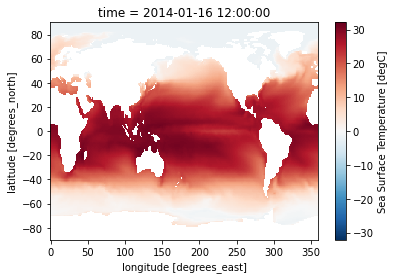

In [11]:
nc = xarray.open_dataset("Data/{}_{}_historical_remapped.nc".format(variable, model))
nc = nc.sel(time = "2014-01")
nc[variable].plot()

## Sea ice selection

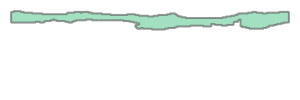

In [12]:
shape = gpd.read_file("Shapes/{}_extended_ice_margin.shp".format(model), crs = "EPSG:4326")
shape['geometry'][0]

In [13]:
ice = gpd.GeoSeries(shape['geometry'][0])

##### ssp585

In [14]:
nc = xarray.open_dataset("Data/{}_{}_{}_remapped.nc".format(variable, model, experiment))
nc = nc.drop_vars("time_bnds")
nc

<xarray.Dataset>
Dimensions:  (time: 1032, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [15]:
# Preparing nc file format for cropping
nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (time: 1032, lon: 360, lat: 180)
Coordinates:
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    spatial_ref  int64 0
Data variables:
    tos          (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [16]:
clipped = nc.rio.clip(ice.geometry.values, crs = 4326, drop = False, all_touched = True)

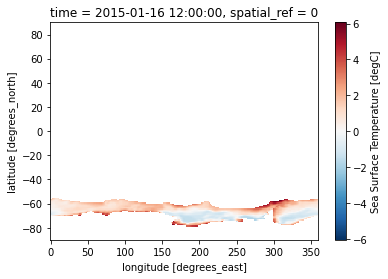

In [17]:
plot = clipped.sel(time = "2015-01")
plot[variable].plot()

In [18]:
clipped.to_netcdf(path = "Data/{}_{}_{}_cropped.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

##### historical


In [19]:
nc = xarray.open_dataset("Data/{}_{}_historical_remapped.nc".format(variable, model))
nc = nc.drop_vars("time_bnds")
nc

<xarray.Dataset>
Dimensions:  (time: 1980, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:48:06 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/688e38fa-19d8-4550-afdd-18f161fa2fdb
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [20]:
# Preparing nc file format for cropping
nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (time: 1980, lon: 360, lat: 180)
Coordinates:
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    spatial_ref  int64 0
Data variables:
    tos          (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:48:06 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/688e38fa-19d8-4550-afdd-18f161fa2fdb
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [21]:
clipped = nc.rio.clip(ice.geometry.values, crs = 4326, drop = False, all_touched = True)

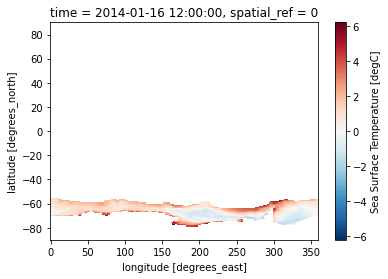

In [22]:
plot = clipped.sel(time = "2014-01")
plot[variable].plot()

In [23]:
clipped.to_netcdf(path = "Data/{}_{}_historical_cropped.nc".format(variable, model), mode = "w", format = "NETCDF4")

## Cropping by export

#### Calculate percentage difference 

##### historical

In [48]:
# Mean of historial last 20 years
historical = xarray.open_dataset("Data/{}_{}_historical_cropped.nc".format(variable, model))
historical

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 1980)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    spatial_ref  int64 ...
    tos          (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:48:06 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/688e38fa-19d8-4550-afdd-18f161fa2fdb
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [49]:
historical_cropped = historical.sel(time=slice('1995-01', '2014-12'))
historical_cropped = historical_cropped.drop_vars("spatial_ref")
historical_cropped

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 240)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:48:06 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/688e38fa-19d8-4550-afdd-18f161fa2fdb
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [26]:
historical_mean = historical_cropped.mean("time")
historical_mean

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

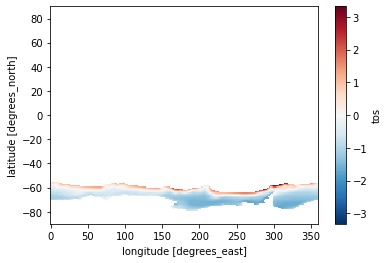

In [27]:
historical_mean[variable].plot()

In [28]:
historical_mean.to_netcdf(path = "Data/{}_{}_historical_20yr.nc".format(variable, model), mode = "w", format = "NETCDF4")

In [50]:
historical_season = historical_cropped.resample(time='QS-DEC').mean(dim="time")

In [51]:
historical_summer = historical_season.sel(time=(historical_season.time.dt.month == 12))
historical_summer = historical_summer.sel(time = slice("1995","2014"))
historical_summer

<xarray.Dataset>
Dimensions:  (time: 20, lat: 180, lon: 360)
Coordinates:
  * time     (time) object 1995-12-01 00:00:00 ... 2014-12-01 00:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [52]:
historical_summer = historical_summer.mean("time")
historical_summer.to_netcdf(path = "Data/{}_{}_historical_20yr_summer.nc".format(variable, model), mode = "w", format = "NETCDF4")

In [53]:
historical_winter = historical_season.sel(time=(historical_season.time.dt.month == 6))

In [54]:
historical_winter = historical_winter.mean("time")
historical_winter.to_netcdf(path = "Data/{}_{}_historical_20yr_winter.nc".format(variable, model), mode = "w", format = "NETCDF4")

##### ssp585

In [55]:
# Mean of ssp585 last 20 years
new = xarray.open_dataset("Data/{}_{}_{}_cropped.nc".format(variable, model, experiment))
new

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    spatial_ref  int64 ...
    tos          (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [56]:
new_cropped = new.sel(time=slice("2081-01","2100-12"))
new_cropped = new_cropped.drop_vars("spatial_ref")
new_cropped

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 240)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2081-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [39]:
new_mean = new_cropped.mean("time")
new_mean

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

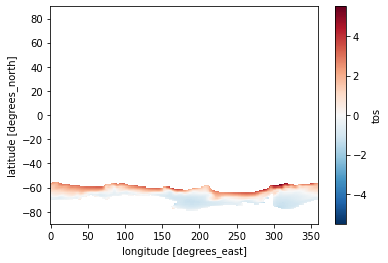

In [40]:
new_mean[variable].plot()

In [41]:
new_mean.to_netcdf(path = "Data/{}_{}_{}_20yr.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

In [57]:
new_season = new_cropped.resample(time='QS-DEC').mean(dim="time")

In [71]:
new_summer = new_season.sel(time=(new_season.time.dt.month == 12))
new_summer = new_summer.sel(time = slice("2081","2100"))
new_summer

<xarray.Dataset>
Dimensions:  (time: 20, lat: 180, lon: 360)
Coordinates:
  * time     (time) object 2081-12-01 00:00:00 ... 2100-12-01 00:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [72]:
new_summer = new_summer.mean("time")
new_summer.to_netcdf(path = "Data/{}_{}_{}_20yr_summer.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

In [86]:
new_winter = new_season.sel(time=(new_season.time.dt.month == 6))
new_winter

<xarray.Dataset>
Dimensions:  (time: 20, lat: 180, lon: 360)
Coordinates:
  * time     (time) object 2081-06-01 00:00:00 ... 2100-06-01 00:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [87]:
new_winter = new_winter.mean("time")
new_winter

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [88]:
new_winter.to_netcdf(path = "Data/{}_{}_{}_20yr_winter.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

##### Difference calculation

In [92]:
# Calculate percentage difference
historical = xarray.open_dataset("Data/{}_{}_historical_20yr.nc".format(variable, model))
new = xarray.open_dataset("Data/{}_{}_{}_20yr.nc".format(variable, model, experiment))

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

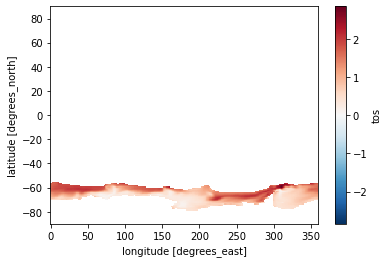

In [93]:
difference = new - historical
difference[variable].plot()
difference

In [94]:
difference.to_netcdf(path = "Data/{}_{}_{}_absolute.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

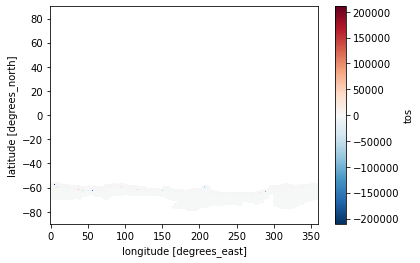

In [95]:
percentage = (difference/historical)*100
percentage[variable].plot()

In [96]:
percentage

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [97]:
percentage.to_netcdf(path = "Data/{}_{}_{}_percentage.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

In [98]:
# summer
historical_summer = xarray.open_dataset("Data/{}_{}_historical_20yr_summer.nc".format(variable, model))
new_summer = xarray.open_dataset("Data/{}_{}_{}_20yr_summer.nc".format(variable, model, experiment))

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

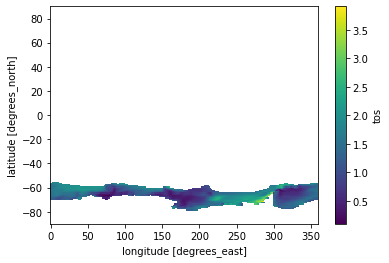

In [99]:
difference_summer = new_summer - historical_summer
difference_summer[variable].plot()
difference_summer

In [100]:
difference_summer.to_netcdf(path = "Data/{}_{}_{}_absolute_summer.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

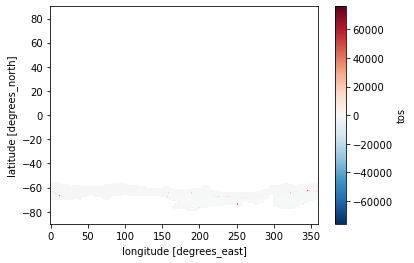

In [101]:
percentage_summer = (difference_summer/historical_summer)*100
percentage_summer[variable].plot()

In [103]:
percentage_summer.to_netcdf(path = "Data/{}_{}_{}_percentage_summer.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

In [48]:
# Winter
historical_winter = xarray.open_dataset("Data/{}_{}_historical_20yr_winter.nc".format(variable, model))
new_winter = xarray.open_dataset("Data/{}_{}_{}_20yr_winter.nc".format(variable, model, experiment))

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

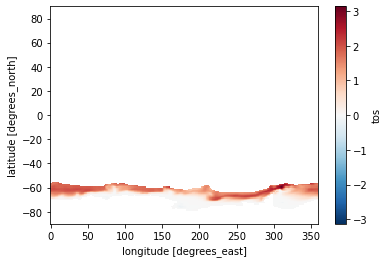

In [52]:
difference_winter = new_winter - historical_winter
difference_winter[variable].plot()
difference_winter

In [53]:
difference_winter.to_netcdf(path = "Data/{}_{}_{}_absolute_winter.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

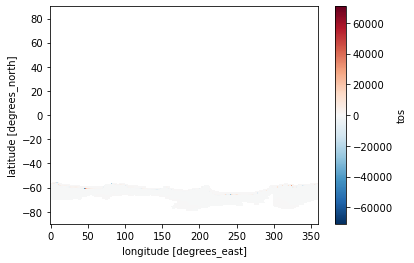

In [54]:
percentage_winter = (difference_winter/historical_winter)*100
percentage_winter[variable].plot()

In [55]:
percentage_winter.to_netcdf(path = "Data/{}_{}_{}_percentage_winter.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

#### Summary values

In [115]:
mean = (percentage.mean())[variable].values
max_value = (percentage.max())[variable].values
min_value = (percentage.min())[variable].values

mean_abs = (difference.mean())[variable].values
max_value_abs = (difference.max())[variable].values
min_value_abs = (difference.min())[variable].values

print("Mean change = {}% {}\n Max inc = {}% {}\n Max dec = {}% {}".format(mean, mean_abs, 
                                                                                                          max_value, max_value_abs,
                                                                                                          min_value, min_value_abs))

Mean change = -168.13583374023438% 1.032444715499878
 Max inc = 72405.9765625% 2.847883701324463
 Max dec = -210303.0% -0.027433156967163086


In [116]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "w")
summary.write("{} {}\n\nOverall:\nMean change = {}% {}\nMax inc = {}% {}\nMax dec = {}% {}".format(variable, model,
                                                                                                                                   mean, mean_abs, 
                                                                                                          max_value, max_value_abs,
                                                                                                          min_value, min_value_abs))
summary.close()

In [325]:
mean_summer = (percentage_summer.mean())[variable].values
max_value_summer = (percentage_summer.max())[variable].values
min_value_summer = (percentage_summer.min())[variable].values

mean_abs_winter = (difference_winter.mean())[variable].values
max_value_abs_winter = (difference_winter.max())[variable].values
min_value_abs_winter = (difference_winter.min())[variable].values


In [326]:
mean_winter = (percentage_winter.mean())[variable].values
max_value_winter = (percentage_winter.max())[variable].values
min_value_winter = (percentage_winter.min())[variable].values

mean_abs_summer = (difference_summer.mean())[variable].values
max_value_abs_summer = (difference_summer.max())[variable].values
min_value_abs_summer = (difference_summer.min())[variable].values

In [328]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "w")
summary.write("n\nSummer:\nMean change = {}% {}\nMax inc = {}% {}\nMax dec = {}% {}".format(mean_summer, mean_abs_summer, 
                                                                                                          max_value_summer, max_value_abs_summer,
                                                                                                          min_value_summer, min_value_abs_summer))
summary.close()

In [329]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "w")
summary.write("\n\nWinter:\nMean change = {}% {}\nMax inc = {}% {}\nMax dec = {}% {}".format(mean_winter, mean_abs_winter, 
                                                                                                          max_value_winter, max_value_abs_winter,
                                                                                                          min_value_winter, min_value_abs_winter))
summary.close()

#### Apply mask

In [117]:
inc = gpd.read_file("Shapes/{}_inc.shp".format(model), crs = "EPSG:4326")
dec = gpd.read_file("Shapes/{}_dec.shp".format(model), crs = "EPSG:4326")

##### Increasing

In [118]:
nc = xarray.open_dataset("Data/{}_{}_{}_cropped.nc".format(variable, model, experiment))

nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

inc_area = nc.rio.clip(inc.geometry.values, crs = 4326, drop = False, all_touched = True)
inc_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 0
Data variables:
    tos          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

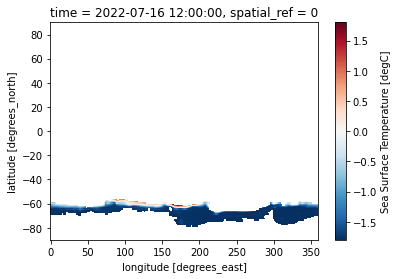

In [119]:
plotting = inc_area.sel(time = "2022-07")
plotting[variable].plot()

In [120]:
vars_list = list(inc_area.data_vars)  
for var in vars_list:  
    del inc_area[var].attrs['grid_mapping']


inc_area.to_netcdf(path = "Data/{}_{}_{}_inc.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

##### Decreasing

In [121]:
dec_area = nc.rio.clip(dec.geometry.values, crs = 4326, drop = False, all_touched = True)
dec_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 0
Data variables:
    tos          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

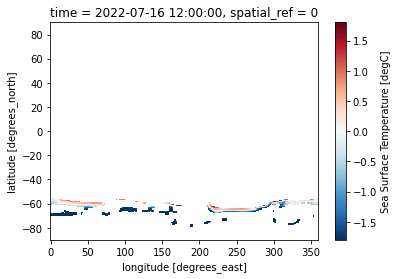

In [122]:
plotting = dec_area.sel(time = "2022-07")
plotting[variable].plot()

In [123]:
vars_list = list(dec_area.data_vars)  
for var in vars_list:  
    del dec_area[var].attrs['grid_mapping']


dec_area.to_netcdf(path = "Data/{}_{}_{}_dec.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

#### Zonal Percentage Change Summary 

In [124]:
inc = gpd.read_file("Shapes/{}_inc.shp".format(model), crs = "EPSG:4326")
dec = gpd.read_file("Shapes/{}_dec.shp".format(model), crs = "EPSG:4326")

##### Increasing

In [125]:
nc = xarray.open_dataset("Data/{}_{}_{}_percentage.nc".format(variable, model, experiment))

nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

inc_area = nc.rio.clip(inc.geometry.values, crs = 4326, drop = False, all_touched = True)
inc_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 0
Data variables:
    tos          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

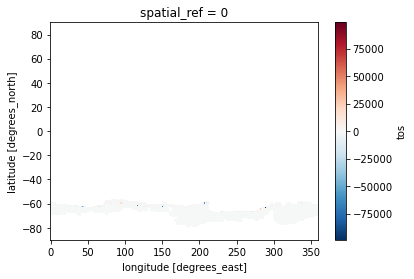

In [126]:
inc_area[variable].plot()

In [127]:
ab = xarray.open_dataset("Data/{}_{}_{}_absolute.nc".format(variable, model, experiment))

ab.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ab.rio.write_crs("epsg:4326", inplace=True)

ab_inc_area = ab.rio.clip(inc.geometry.values, crs = 4326, drop = False, all_touched = True)
ab_inc_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 0
Data variables:
    tos          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

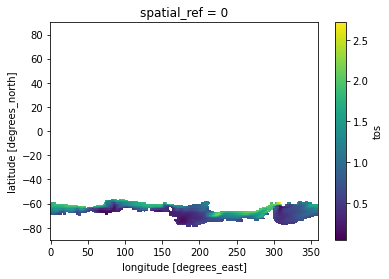

In [128]:
ab_inc_area[variable].plot()

In [129]:
inc_mean = (inc_area.mean())[variable].values
inc_max_value = (inc_area.max())[variable].values
inc_min_value = (inc_area.min())[variable].values

inc_mean_abs = (ab_inc_area.mean())[variable].values
inc_max_value_abs = (ab_inc_area.max())[variable].values
inc_min_value_abs = (ab_inc_area.min())[variable].values

print("Mean change = {}% {}\n Max inc = {}% {}\n Max dec = {}% {}\n".format(inc_mean, inc_mean_abs, 
                                                                            inc_max_value, inc_max_value_abs,
                                                                            inc_min_value, inc_min_value_abs))

Mean change = -155.17884826660156% 0.9487155675888062
 Max inc = 72405.9765625% 2.7157351970672607
 Max dec = -98796.453125% 0.04391428828239441



In [130]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nIncreasing zone:\nMean change = {}% {}\nMax inc = {}% {}\nMax dec = {}% {}\n".format(inc_mean, inc_mean_abs, 
                                                                            inc_max_value, inc_max_value_abs,
                                                                            inc_min_value, inc_min_value_abs))
summary.close()

##### Decreasing

In [131]:
dec_area = nc.rio.clip(dec.geometry.values, crs = 4326, drop = False, all_touched = True)
dec_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 0
Data variables:
    tos          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

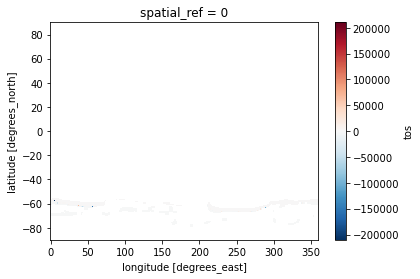

In [132]:
dec_area[variable].plot()

In [133]:
ab_dec_area = ab.rio.clip(dec.geometry.values, crs = 4326, drop = False, all_touched = True)
ab_dec_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 0
Data variables:
    tos          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

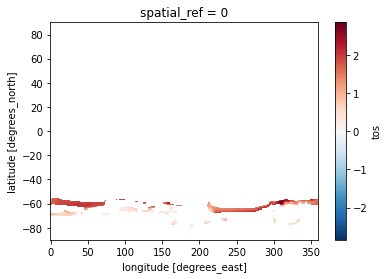

In [134]:
ab_dec_area[variable].plot()

In [135]:
dec_mean = (dec_area.mean())[variable].values
dec_max_value = (dec_area.max())[variable].values
dec_min_value = (dec_area.min())[variable].values

dec_mean_abs = (ab_dec_area.mean())[variable].values
dec_max_value_abs = (ab_dec_area.max())[variable].values
dec_min_value_abs = (ab_dec_area.min())[variable].values

print("Mean change = {}% {}\n Max inc = {}% {}\n Max dec = {}% {}\n".format(dec_mean, dec_mean_abs, 
                                                                            dec_max_value, dec_max_value_abs,
                                                                            dec_min_value, dec_min_value_abs))

Mean change = -302.87542724609375% 1.3241543769836426
 Max inc = 68908.5078125% 2.847883701324463
 Max dec = -210303.0% -0.027433156967163086



In [136]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nDecreasing zone:\nMean change = {}% {}\nMax inc = {}% {}\nMax dec = {}% {}\n".format(dec_mean, dec_mean_abs, 
                                                                            dec_max_value, dec_max_value_abs,
                                                                            dec_min_value, dec_min_value_abs))
summary.close()

## Absolute map

##### historical

In [137]:
# Annual mean at 2014
historical = xarray.open_dataset("Data/{}_{}_historical_cropped.nc".format(variable, model))
historical = historical.drop_vars("spatial_ref")
historical

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1980)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:48:06 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/688e38fa-19d8-4550-afdd-18f161fa2fdb
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [138]:
historical_end = historical.sel(time = "2014")
historical_end

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2014-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:48:06 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/688e38fa-19d8-4550-afdd-18f161fa2fdb
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, year: 1)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * year     (year) int64 2014
Data variables:
    tos      (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

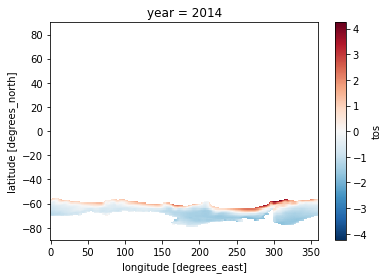

In [139]:
historical_mean = historical_end.groupby("time.year").mean("time")
historical_mean[variable].plot()
historical_mean

In [140]:
historical_mean.to_netcdf(path = "Data/{}_{}_historical_2014.nc".format(variable, model), mode = "w", format = "NETCDF4")

##### ssp585

In [141]:
# Annual mean at 2100
new = xarray.open_dataset("Data/{}_{}_{}_cropped.nc".format(variable, model, experiment))
new = new.drop_vars("spatial_ref")
new

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [142]:
new_end = new.sel(time = "2100")
new_end

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2100-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, year: 1)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * year     (year) int64 2100
Data variables:
    tos      (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

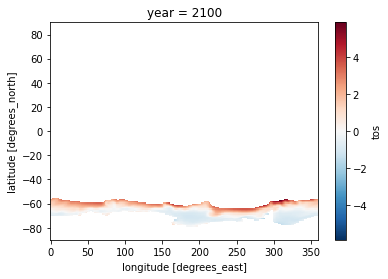

In [143]:
new_mean = new_end.groupby("time.year").mean("time")
new_mean[variable].plot()
new_mean

In [144]:
new_mean.to_netcdf(path = "Data/{}_{}_{}_2100.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

##### Summary values

In [145]:
print("Mean at 2014 is: {}".format(historical_mean.mean()[variable].values))
print("Mean at 2100 is: {}".format(new_mean.mean()[variable].values))

Mean at 2014 is: -0.43292394280433655
Mean at 2100 is: 0.6507534980773926


##### Mapping

In [146]:
inc = gpd.read_file("Shapes/{}_inc_remapped_improved.shp".format(model))
dec = gpd.read_file("Shapes/{}_dec_remapped_improved.shp".format(model))

In [147]:
# Finding max/min value between the two years
old = xarray.open_dataset("Data/{}_{}_historical_2014.nc".format(variable, model))
new = xarray.open_dataset("Data/{}_{}_{}_2100.nc".format(variable, model, experiment))

In [148]:
lat_old = old['lat'].values 
lon_old = old['lon'].values
var_old = old[variable].values

var_old = np.nanmean(var_old, axis = 0) 

old_max = np.nanmax(var_old)
old_min = np.nanmin(var_old)
print(old_max, old_min)


var_old, lon_old = add_cyclic_point(var_old, coord=lon_old)
x, y = np.meshgrid(lon_old, lat_old)

4.2373433 -1.7999994


/tmp/ipykernel_13248/3715887452.py:5: RuntimeWarning: Mean of empty slice


In [149]:
lat_new = new['lat'].values 
lon_new = new['lon'].values
var_new = new[variable].values

var_new = np.nanmean(var_new, axis = 0) 

new_max = np.nanmax(var_new)
new_min = np.nanmin(var_new)
print(new_max, new_min)


var_new, lon_new = add_cyclic_point(var_new, coord=lon_new)
x_new, y_new = np.meshgrid(lon_new, lat_new)

5.888088 -1.6800445


/tmp/ipykernel_13248/1500621824.py:5: RuntimeWarning: Mean of empty slice


In [150]:
overall_max = max(old_max, new_max)
overall_min = min(old_min, new_min)
print(overall_max, overall_min)

5.888088 -1.7999994


/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteratio

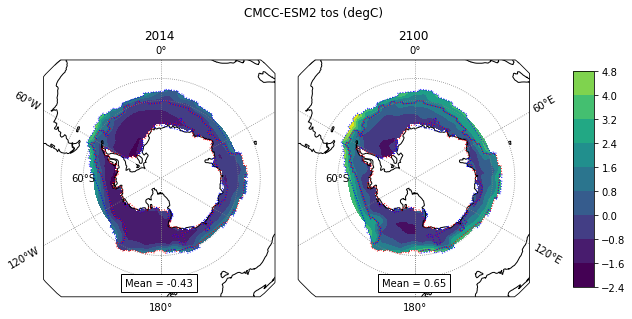

In [156]:
fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(1, 2, 1, projection=cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90))
ax2 = fig.add_subplot(1, 2, 2, projection=cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                               sharex=ax1, sharey=ax1)
fig.subplots_adjust(wspace=0.1)

plt.suptitle("{} {} ({})".format(model, variable, unit))


# 2014 plot
ax1.set_extent([-180, 180, -90, -40], cartopy.crs.PlateCarree())

gl1 = ax1.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = ':',
                  y_inline = True,
                  x_inline = False) 

gl1.right_labels = False

gl1.ylabel_style = {'size': 10}
gl1.xlabel_style = {'size': 10}

gl1.ylocator = mticker.FixedLocator([-60, -50])

plt.draw()
for ea in gl1.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])



ax1.title.set_text('2014')

p = ax1.contourf(x, y, var_old,
                vmax = overall_max, vmin = overall_min,
                cmap = 'viridis',
                transform = cartopy.crs.PlateCarree())

ax1.coastlines()

ax1.add_geometries(inc['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'red',
                  linestyle = ':')

ax1.add_geometries(dec['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'blue',
                  linestyle = ':')


mean2014 = AnchoredText("Mean = {0:.2f}".format(historical_mean.mean()[variable].values), loc="lower center")
ax1.add_artist(mean2014)


# 2100 plot
ax2.set_extent([-180, 180, -90, -40], cartopy.crs.PlateCarree())

gl2 = ax2.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = ':',
                  y_inline = True,
                  x_inline = False) 

gl2.left_labels = False

gl2.ylabel_style = {'size': 10}
gl2.xlabel_style = {'size': 10}

gl2.ylocator = mticker.FixedLocator([-60, -50])

plt.draw()
for ea in gl2.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])

ax2.title.set_text('2100')

p2 = ax2.contourf(x_new, y_new, var_new,
                vmax = overall_max, vmin = overall_min,
                cmap = 'viridis',
                transform = cartopy.crs.PlateCarree())

ax2.coastlines()

ax2.add_geometries(inc['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'red',
                  linestyle = ':')

ax2.add_geometries(dec['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'blue',
                  linestyle = ':')

mean2100 = AnchoredText("Mean = {0:.2f}".format(new_mean.mean()[variable].values), loc="lower center")
ax2.add_artist(mean2100)



### Colorbar
fig.subplots_adjust(right=0.8) # Move all subplots 0.2 away from the right
cbar_ax = fig.add_axes([0.86, 0.2, 0.03, 0.6]) # Define position and size of new element (distance from left, distance from bottom, width, height)
fig.colorbar(p, cax=cbar_ax)


plt.savefig("output/CMCC-ESM2/{}_{}_2014vs2100.png".format(variable, model))

plt.show()

## Percentage Change map

In [164]:
nc = xarray.open_dataset("Data/{}_{}_{}_percentage.nc".format(variable, model, experiment))
nc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tos      (lat, lon) float32 ...

In [165]:
lat = nc['lat'].values 
lon = nc['lon'].values
var = nc[variable].values

var_max = np.nanmax(var)
var_min = np.nanmin(var)
label = abs(max([var_min, var_max], key = abs))
print(var_max, var_min)

var, lon = add_cyclic_point(var, coord=lon)
x, y = np.meshgrid(lon, lat)

72405.98 -210303.0


In [186]:
var_mean = np.nanmean(var)
var_mean

-170.54414

In [166]:
nc_summer = xarray.open_dataset("Data/{}_{}_{}_percentage_summer.nc".format(variable, model, experiment))

In [178]:
lat_summer = nc_summer['lat'].values 
lon_summer = nc_summer['lon'].values
var_summer = nc_summer[variable].values

var_max_summer = np.nanmax(var_summer)
var_min_summer = np.nanmin(var_summer)
label = abs(max([var_min, var_max], key = abs))
print(var_max_summer, var_min_summer)

var_summer, lon_summer = add_cyclic_point(var_summer, coord=lon_summer)
x_summer, y_summer = np.meshgrid(lon_summer, lat_summer)

68539.86 -76030.16


In [187]:
var_mean_summer = np.nanmean(var_summer)

In [168]:
nc_winter = xarray.open_dataset("Data/{}_{}_{}_percentage_winter.nc".format(variable, model, experiment))

In [179]:
lat_winter = nc_winter['lat'].values 
lon_winter = nc_winter['lon'].values
var_winter = nc_winter[variable].values

var_max_winter = np.nanmax(var_winter)
var_min_winter = np.nanmin(var_winter)
label = abs(max([var_min, var_max], key = abs))
print(var_max_winter, var_min_winter)

var_winter, lon_winter = add_cyclic_point(var_winter, coord=lon_winter)
x_winter, y_winter = np.meshgrid(lon_winter, lat_winter)

72405.98 -210303.0


In [188]:
var_mean_winter = np.nanmean(var_winter)

In [170]:
inc = gpd.read_file("Shapes/{}_inc_remapped_improved.shp".format(model))
dec = gpd.read_file("Shapes/{}_dec_remapped_improved.shp".format(model))

In [206]:
overall_max = max(var_max, var_max_summer, var_max_winter)
overall_min = min(var_min, var_min_summer, var_min_winter)
print(overall_max, overall_min)

72405.98 -210303.0


/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteratio

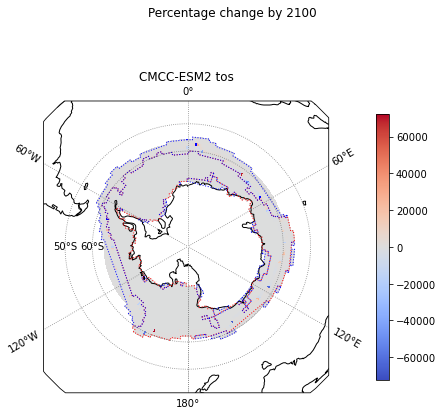

In [207]:
fig = plt.figure(figsize=[7, 7])
ax1 = fig.add_subplot(1, 1, 1, projection=cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90))


plt.suptitle("Percentage change by 2100")


ax1.set_extent([-180, 180, -90, -40], cartopy.crs.PlateCarree())

gl1 = ax1.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = ':',
                  y_inline = True,
                  x_inline = False) 


gl1.ylabel_style = {'size': 10}
gl1.xlabel_style = {'size': 10}

gl1.ylocator = mticker.FixedLocator([-60, -50])

plt.draw()
for ea in gl1.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])



ax1.title.set_text("{} {}".format(model, variable))

divnorm = colors.TwoSlopeNorm(vmin = -overall_max, vcenter = 0., vmax = overall_max)
#divnorm = colors.TwoSlopeNorm(vcenter = 0.)

p = ax1.pcolor(x, y, var, 
              cmap = 'coolwarm', norm = divnorm, transform = cartopy.crs.PlateCarree() )
#cmap = mpl.cm.get_cmap("coolwarm").copy()
# p.cmap.set_under("blue")
# p.cmap.set_over("red")
# p.set_clim(-overall_max, overall_max)

ax1.coastlines()

ax1.add_geometries(inc['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'red',
                  linestyle = ':')

ax1.add_geometries(dec['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'blue',
                  linestyle = ':')

cb = plt.colorbar(p, shrink=0.7, pad = 0.12)

plt.savefig("output/CMCC-ESM2/{}_{}_percentage_change.png".format(variable, model))

plt.show()

## Zonal Mean Summary 

### Increasing

In [209]:
inc = gpd.read_file("Shapes/{}_inc.shp".format(model), crs = "EPSG:4326")
dec = gpd.read_file("Shapes/{}_dec.shp".format(model), crs = "EPSG:4326")

In [210]:
new = xarray.open_dataset("Data/{}_{}_{}_20yr.nc".format(variable, model, experiment))
new_mean = np.nanmean(new[variable].values)
new_max = np.nanmax(new[variable].values)
new_min = np.nanmin(new[variable].values)
print(new_mean)     

0.5067662


In [211]:
new.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
new.rio.write_crs("epsg:4326", inplace=True)

new_inc = new.rio.clip(inc.geometry.values, crs = 4326, drop = False, all_touched = True)

In [212]:
new_inc_mean = np.nanmean(new_inc[variable].values)
new_inc_max = np.nanmax(new_inc[variable].values)
new_inc_min = np.nanmin(new_inc[variable].values)

print(new_inc_mean, new_inc_max, new_inc_min)

0.2174144 3.837357 -1.3677386


In [213]:
historical = xarray.open_dataset("Data/{}_{}_historical_20yr.nc".format(variable, model))
historical_mean = np.nanmean(historical[variable].values)
historical_max = np.nanmax(historical[variable].values)
historical_min = np.nanmin(historical[variable].values)
print(historical_mean)     

-0.5256785


In [214]:
historical.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
historical.rio.write_crs("epsg:4326", inplace=True)

historical_inc = historical.rio.clip(inc.geometry.values, crs = 4326, drop = False, all_touched = True)

In [215]:
historical_inc_mean = np.nanmean(historical_inc[variable].values)
historical_inc_max = np.nanmax(historical_inc[variable].values)
historical_inc_min = np.nanmin(historical_inc[variable].values)

print(historical_inc_mean, historical_inc_max, historical_inc_min)

-0.7313012 2.2094095 -1.7999309


### Decreasing

In [216]:
new.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
new.rio.write_crs("epsg:4326", inplace=True)

new_dec = new.rio.clip(dec.geometry.values, crs = 4326, drop = False, all_touched = True)

In [217]:
new_dec_mean = np.nanmean(new_dec[variable].values)
new_dec_max = np.nanmax(new_dec[variable].values)
new_dec_min = np.nanmin(new_dec[variable].values)

print(new_dec_mean, new_dec_max, new_dec_min)

1.4744365 5.5147653 -1.2567859


In [218]:
historical.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
historical.rio.write_crs("epsg:4326", inplace=True)

historical_dec = historical.rio.clip(dec.geometry.values, crs = 4326, drop = False, all_touched = True)

In [219]:
historical_dec_mean = np.nanmean(historical_dec[variable].values)
historical_dec_max = np.nanmax(historical_dec[variable].values)
historical_dec_min = np.nanmin(historical_dec[variable].values)

print(historical_dec_mean, historical_dec_max, historical_dec_min)

0.1502821 3.3226686 -1.6548684


In [220]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nOverall:\nNew mean = {}m\nNew max = {}m\nNew min = {}m".format(new_mean, new_max, new_min))
summary.write("\n\nHistorical mean = {}m\nHistorical max = {}m\nHistorical min = {}m".format(historical_mean, historical_max, historical_min))

summary.write("\n\n\nIncreasing zone:\nNew mean = {}m\nNew max = {}m\nNew min = {}m".format(new_inc_mean, new_inc_max, new_inc_min))
summary.write("\n\nHistorical mean = {}m\nHistorical max = {}m\nHistorical min = {}m".format(historical_inc_mean, historical_inc_max, historical_inc_min))

summary.write("\n\n\nDecreasing zone:\nNew mean = {}m\nNew max = {}m\nNew min = {}m".format(new_dec_mean, new_dec_max, new_dec_min))
summary.write("\n\nHistorical mean = {}m\nHistorical max = {}m\nHistorical min = {}m".format(historical_dec_mean, historical_dec_max, historical_dec_min))
summary.close()

## Mean regression 

### Total


In [221]:
# Change in annual mean value 
nc = xarray.open_dataset("Data/{}_{}_{}_cropped.nc".format(variable, model, experiment))
nc = nc.drop_vars("spatial_ref")
nc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [222]:
spatial_mean = nc.groupby("time").mean(["lat", "lon"])
spatial_mean

<xarray.Dataset>
Dimensions:  (time: 1032)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time) float32 0.9149 1.238 0.68 -0.06735 ... -0.6537 -0.1088 1.183

In [223]:
year_mean = spatial_mean.groupby("time.year").mean("time")
year_mean

<xarray.Dataset>
Dimensions:  (year: 86)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables:
    tos      (year) float32 -0.5281 -0.5595 -0.5061 ... 0.5209 0.5553 0.6508

In [224]:
var_mean = year_mean[variable].values

In [225]:
time = year_mean['year'].values
time

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])

In [226]:
yearly_summer = []
yearly_winter = []

In [227]:
for i in time:
    year = spatial_mean.sel(time = "{}".format(i))
    
    season_mean = year.groupby("time.season").mean("time")

    summer = season_mean.sel(season = "DJF")[variable].values
    summer = summer.tolist()
    winter = season_mean.sel(season = "JJA")[variable].values
    winter = winter.tolist()
    
    yearly_summer.append(summer)
    yearly_winter.append(winter)
    

In [228]:
data = {'Year': time,
        'Annual': var_mean,
        'Summer': yearly_summer,
        'Winter': yearly_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,-0.528090,0.569018,-1.257553,CMCC-ESM2
1,2016,-0.559462,0.430124,-1.218379,CMCC-ESM2
2,2017,-0.506074,0.495119,-1.171575,CMCC-ESM2
3,2018,-0.489424,0.547478,-1.191254,CMCC-ESM2
4,2019,-0.369983,0.638991,-1.064137,CMCC-ESM2
...,...,...,...,...,...
81,2096,0.573613,1.714248,-0.220373,CMCC-ESM2
82,2097,0.508739,1.742659,-0.304651,CMCC-ESM2
83,2098,0.520879,1.756565,-0.313159,CMCC-ESM2
84,2099,0.555349,1.847015,-0.305685,CMCC-ESM2


In [229]:
df.to_csv("csv/{}_{}_whole.csv".format(model, variable), index = False, header=True)

#### Plotting


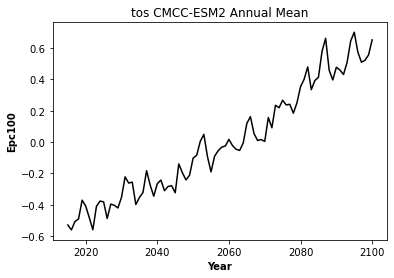

In [230]:
fig, ax = plt.subplots()

ax.plot(time, var_mean, 'k')
#ax.plot(time, yearly_summer, 'r')
#ax.plot(time, yearly_winter, 'b')

ax.title.set_text("{} {} Annual Mean".format(variable, model))

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Epc100")
plt.xlabel("Year")

#plt.savefig("output/{}_{}_{}_projection_annual_mean.png".format(variable, model, experiment))

plt.show()

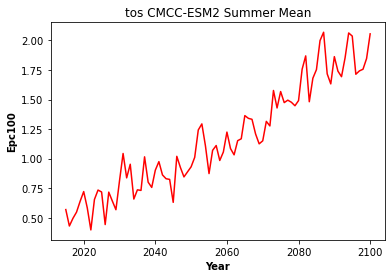

In [231]:
fig, ax = plt.subplots()

#ax.plot(time, var_mean, 'k')
ax.plot(time, yearly_summer, 'r')
#ax.plot(time, yearly_winter, 'b')

ax.title.set_text("{} {} Summer Mean".format(variable, model))

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Epc100")
plt.xlabel("Year")

#plt.savefig("output/{}_{}_{}_projection_summer_mean.png".format(variable, model, experiment))

plt.show()

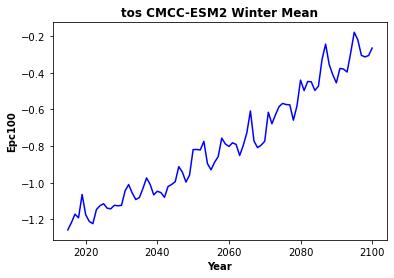

In [232]:
fig, ax = plt.subplots()

#ax.plot(time, var_mean, 'k')
#ax.plot(time, yearly_summer, 'r')
ax.plot(time, yearly_winter, 'b')

plt.title("{} {} Winter Mean".format(variable, model),fontweight="bold")

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Epc100")
plt.xlabel("Year")

#plt.savefig("output/{}_{}_{}_projection_winter_mean.png".format(variable, model, experiment))

plt.show()

In [36]:
annual_inflection = 2034.4

annual_point = np.where(time == int(annual_inflection))[0].tolist()
annual_label = int(annual_inflection)
annual_position = (annual_label, var_mean[annual_point][0])


# summer_inflection = 2052.9

# summer_point = np.where(time == int(summer_inflection))[0].tolist()
# summer_label = int(summer_inflection)
# summer_position = (summer_label, yearly_summer[summer_point[0]])


# winter_inflection = 2052.9

# winter_point = np.where(time == int(winter_inflection))[0].tolist()
# winter_label = int(winter_inflection)
# winter_position = (winter_label, yearly_winter[winter_point[0]])

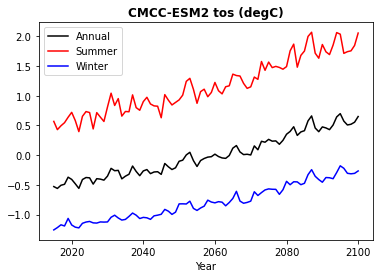

In [234]:
fig, ax = plt.subplots()

ax.plot(time, var_mean, '-k', label = "Annual")
ax.plot(time, yearly_summer, '-r', label = "Summer")
ax.plot(time, yearly_winter, '-b', label = "Winter")

#plt.annotate(annual_label, annual_position, textcoords="offset points", xytext=(0,10), ha='center') 
#plt.annotate(summer_label, summer_position, textcoords="offset points",xytext=(0,12), ha='center') 
#plt.annotate(winter_label, winter_position, textcoords="offset points",xytext=(0,12), ha='center') 

plt.title("{} {} ({})".format(model, variable, unit), fontweight="bold")

#ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
#ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

#plt.ylabel("Epc100")
plt.xlabel("Year")

# bbox_to_anchor specify the position (x,y) of box in graph from the corner of the box specified by loc
plt.legend()

plt.savefig("output/CMCC-ESM2/{}_{}_{}_mean_projection_whole.png".format(variable, model, experiment))

plt.show()

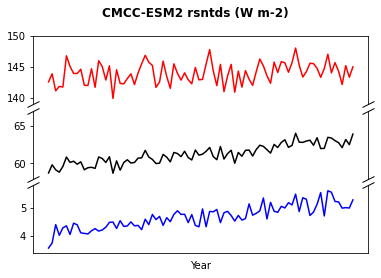

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0.1)  

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places

ax2.plot(time, var_mean, '-k', label = "Annual")
ax1.plot(time, yearly_summer, '-r', label = "Summer")
ax3.plot(time, yearly_winter, '-b', label = "Winter")

ax1.set_ylim(139, 150)  
ax2.set_ylim(58, 67) 
ax3.set_ylim(4.2,5.4)

plt.suptitle("{} {} ({})".format(model, variable, unit), fontweight="bold")

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax2.spines.bottom.set_visible(False)
ax3.spines.top.set_visible(False)
#ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax3.xaxis.tick_bottom()
ax2.set_xticks([])
ax1.set_xticks([])

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)

plt.xlabel("Year")

#plt.legend(loc="lower left", bbox_to_anchor=(1.2, 0.2))

plt.savefig("output/CMCC-ESM2/{}_{}_{}_mean_projection_whole.png".format(variable, model, experiment))

plt.show()

### Zonal

##### Increasing zone

In [235]:
inc = xarray.open_dataset("Data/{}_{}_{}_inc.nc".format(variable, model, experiment))
inc = inc.drop_vars("spatial_ref")
inc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [236]:
inc_spatial_mean = inc.groupby("time").mean(["lat", "lon"])
inc_spatial_mean

<xarray.Dataset>
Dimensions:  (time: 1032)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time) float32 0.6725 1.028 0.4547 ... -0.9771 -0.4417 0.8526

In [237]:
inc_year_mean = inc_spatial_mean.groupby("time.year").mean("time")
inc_year_mean

<xarray.Dataset>
Dimensions:  (year: 86)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables:
    tos      (year) float32 -0.7321 -0.773 -0.7239 ... 0.2327 0.2576 0.345

In [238]:
inc_mean = inc_year_mean[variable].values

In [239]:
time = inc_year_mean['year'].values

In [240]:
inc_yearly_summer = []
inc_yearly_winter = []

In [241]:
for i in time:
    year = inc_spatial_mean.sel(time = "{}".format(i))
    
    season_mean = year.groupby("time.season").mean("time")

    summer = season_mean.sel(season = "DJF")[variable].values
    summer = summer.tolist()
    winter = season_mean.sel(season = "JJA")[variable].values
    winter = winter.tolist()
    
    inc_yearly_summer.append(summer)
    inc_yearly_winter.append(winter)
    

In [242]:
data = {'Year': time,
        'Annual': inc_mean,
        'Summer': inc_yearly_summer,
        'Winter': inc_yearly_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,-0.732069,0.338712,-1.457708,CMCC-ESM2
1,2016,-0.773042,0.186275,-1.427019,CMCC-ESM2
2,2017,-0.723890,0.249235,-1.384839,CMCC-ESM2
3,2018,-0.715919,0.290065,-1.416354,CMCC-ESM2
4,2019,-0.585380,0.418112,-1.291506,CMCC-ESM2
...,...,...,...,...,...
81,2096,0.269818,1.419199,-0.541583,CMCC-ESM2
82,2097,0.215090,1.459648,-0.613205,CMCC-ESM2
83,2098,0.232666,1.478907,-0.616429,CMCC-ESM2
84,2099,0.257618,1.558564,-0.621397,CMCC-ESM2


In [243]:
df.to_csv("csv/{}_{}_inc.csv".format(model, variable), index = False, header=True)

##### Decreasing zone

In [244]:
dec = xarray.open_dataset("Data/{}_{}_{}_dec.nc".format(variable, model, experiment))
dec = dec.drop_vars("spatial_ref")
dec

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Aug 04 10:47:42 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ddf593f1-127a-480c-884f-c8c5cb0588a2
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [245]:
dec_spatial_mean = dec.groupby("time").mean(["lat", "lon"])
dec_spatial_mean

<xarray.Dataset>
Dimensions:  (time: 1032)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tos      (time) float32 1.808 2.032 1.511 0.7782 ... 0.3995 0.9887 2.281

In [246]:
dec_year_mean = dec_spatial_mean.groupby("time.year").mean("time")
dec_year_mean

<xarray.Dataset>
Dimensions:  (year: 86)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables:
    tos      (year) float32 0.1513 0.1473 0.2159 0.2528 ... 1.492 1.543 1.668

In [247]:
dec_mean = dec_year_mean[variable].values

In [248]:
dec_yearly_summer = []
dec_yearly_winter = []

In [249]:
for i in time:
    year = dec_spatial_mean.sel(time = "{}".format(i))
    
    season_mean = year.groupby("time.season").mean("time")

    summer = season_mean.sel(season = "DJF")[variable].values
    summer = summer.tolist()
    winter = season_mean.sel(season = "JJA")[variable].values
    winter = winter.tolist()
    
    dec_yearly_summer.append(summer)
    dec_yearly_winter.append(winter)
    

In [250]:
time = dec_year_mean['year'].values

In [251]:
data = {'Year': time,
        'Annual': dec_mean,
        'Summer': dec_yearly_summer,
        'Winter': dec_yearly_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,0.151326,1.392685,-0.640368,CMCC-ESM2
1,2016,0.147328,1.279405,-0.564023,CMCC-ESM2
2,2017,0.215870,1.352124,-0.507132,CMCC-ESM2
3,2018,0.252777,1.432237,-0.495589,CMCC-ESM2
4,2019,0.356615,1.403323,-0.320629,CMCC-ESM2
...,...,...,...,...,...
81,2096,1.583808,2.700680,0.831605,CMCC-ESM2
82,2097,1.489612,2.702591,0.708073,CMCC-ESM2
83,2098,1.491521,2.702906,0.682327,CMCC-ESM2
84,2099,1.543021,2.823339,0.716584,CMCC-ESM2


In [252]:
df.to_csv("csv/{}_{}_dec.csv".format(model, variable), index = False, header=True)

##### Plotting

In [253]:
inc_inflection = 2034.4

inc_point = np.where(time == int(inc_inflection))[0].tolist()
inc_label = int(inc_inflection)
inc_position = (inc_label, inc_mean[inc_point][0])


# dec_inflection = 

# dec_point = np.where(time == int(dec_inflection))[0].tolist()
# dec_label = int(dec_inflection)
# dec_position = (dec_label, dec_mean[dec_point][0])

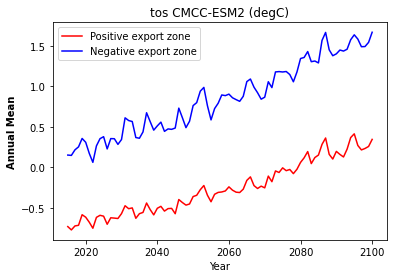

In [254]:
fig, ax = plt.subplots()


ax.plot(time, inc_mean, '-r', label = "Positive export zone")
ax.plot(time, dec_mean, '-b', label = "Negative export zone")


#plt.annotate(inc_label, inc_position, textcoords="offset points", xytext=(0,10), ha='center') 
#plt.annotate(dec_label, dec_position, textcoords="offset points",xytext=(0,12), ha='center') 


plt.title("{} {} ({})".format(variable, model, unit))

#ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual Mean")
plt.xlabel("Year")

plt.legend()

plt.savefig("output/CMCC-ESM2/{}_{}_{}_annual_projection_by_zone.png".format(variable, model, experiment))

plt.show()

In [216]:
# inc_inflection = 2052.9

# inc_point = np.where(time == int(inc_inflection))[0].tolist()
# inc_label = int(inc_inflection)
# inc_position = (inc_label, inc_yearly_summer[inc_point[0]])


# dec_inflection = 

# dec_point = np.where(time == int(dec_inflection))[0].tolist()
# dec_label = int(dec_inflection)
# dec_position = (dec_label, dec_yearly_summer[dec_point[0]])

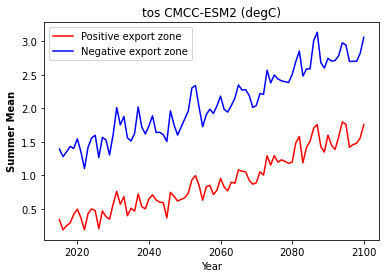

In [255]:
fig, ax = plt.subplots()


ax.plot(time, inc_yearly_summer, '-r', label = "Positive export zone")
ax.plot(time, dec_yearly_summer, '-b', label = "Negative export zone")

#plt.annotate(inc_label, inc_position, textcoords="offset points", xytext=(0,10), ha='center') 
#plt.annotate(dec_label, dec_position, textcoords="offset points",xytext=(0,12), ha='center') 


plt.title("{} {} ({})".format(variable, model, unit))

#ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer Mean")
plt.xlabel("Year")

plt.legend()

plt.savefig("output/CMCC-ESM2/{}_{}_{}_summer_projection_by_zone.png".format(variable, model, experiment))

plt.show()

In [53]:
# inc_inflection = 2052.9

# inc_point = np.where(time == int(inc_inflection))[0].tolist()
# inc_label = int(inc_inflection)
# inc_position = (inc_label, inc_yearly_winter[inc_point[0]])


# dec_inflection = 

# dec_point = np.where(time == int(dec_inflection))[0].tolist()
# dec_label = int(dec_inflection)
# dec_position = (dec_label, dec_yearly_winter[dec_point[0]])

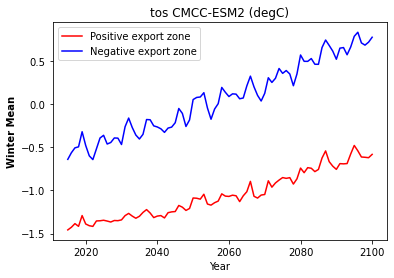

In [257]:
fig, ax = plt.subplots()


ax.plot(time, inc_yearly_winter, 'r', label = "Positive export zone")
ax.plot(time, dec_yearly_winter, 'b', label = "Negative export zone")

#plt.annotate(inc_label, inc_position, textcoords="offset points", xytext=(0,10), ha='center') 
#plt.annotate(dec_label, dec_position, textcoords="offset points",xytext=(0,12), ha='center') 


plt.title("{} {} ({})".format(variable, model, unit))

#ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter Mean")
plt.xlabel("Year")

plt.legend()

plt.savefig("output/CMCC-ESM2/{}_{}_{}_winter_projection_by_zone.png".format(variable, model, experiment))

plt.show()

## Correlation with epc100

### 20 year change correlation

#### Percentage

In [258]:
current_inc_per = xarray.open_dataarray("Data/{}_{}_{}_percentage.nc".format(variable, model, experiment))
exp_inc_per = xarray.open_dataarray("Data/epc100_{}_{}_percentage.nc".format(model, experiment))

In [259]:
cor_per = xarray.corr(current_inc_per, exp_inc_per, dim = ["lat", "lon"])
cor_per

<xarray.DataArray ()>
array(0.01433481)
Coordinates:
    depth    float64 100.0

In [260]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nPercentage correlation with epc100: {}".format(cor_per.values))
summary.close()

#### Absolute

In [261]:
current_inc_abs = xarray.open_dataarray("Data/{}_{}_{}_absolute.nc".format(variable, model, experiment))
exp_inc_abs = xarray.open_dataarray("Data/epc100_{}_{}_absolute.nc".format(model, experiment))

In [262]:
cor_abs = xarray.corr(current_inc_abs, exp_inc_abs, dim = ["lat", "lon"])
cor_abs

<xarray.DataArray ()>
array(-0.25839046)
Coordinates:
    depth    float64 100.0

In [263]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\nAbsolute correlation with epc100: {}".format(cor_abs.values))
summary.close()

### Spatial correlation 

#### Increasing zone


In [7]:
current_inc = xarray.open_dataarray("Data/{}_{}_{}_inc.nc".format(variable, model, experiment),decode_coords="all")
current_inc

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello']


<xarray.DataArray 'tos' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    units:          degC
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    cell_methods:   area: mean where sea time: mean

In [8]:
epc = xarray.open_dataarray("Data/epc100_{}_{}_inc.nc".format(model, experiment), decode_coords="all")
epc

<xarray.DataArray 'epc100' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    depth        float64 ...
    spatial_ref  int64 ...
Attributes:
    standard_name:  sinking_mole_flux_of_particulate_organic_matter_expressed...
    long_name:      Downward Flux of Particulate Organic Carbon
    units:          mol m-2 s-1
    comment:        The phrase 'expressed_as' is used in the construction A_e...
    original_name:  expc (levid 19)
    cell_methods:   area: mean where sea time: mean
    history:        2021-01-20T13:14:42Z altered by CMOR: Treated scalar dime...

In [9]:
cor_inc = xarray.corr(current_inc, epc, dim = ["lat", "lon"])
cor_inc = cor_inc.groupby("time.year").mean("time")
cor_inc

<xarray.DataArray (year: 86)>
array([ 0.26966642,  0.31828566,  0.30412921,  0.21697292,  0.24404422,
        0.25526484,  0.25155057,  0.29197832,  0.28067921,  0.2853272 ,
        0.26491105,  0.28469648,  0.21909108,  0.19546044,  0.2548556 ,
        0.29130265,  0.20268081,  0.20882668,  0.25884344,  0.25487134,
        0.24625068,  0.22679881,  0.11953509,  0.18524739,  0.25577891,
        0.22534136,  0.21530654,  0.27011914,  0.32051022,  0.28471202,
        0.24848653,  0.2449827 ,  0.23971294,  0.25676384,  0.22989354,
        0.20972365,  0.1970353 ,  0.16946624,  0.22430788,  0.23271725,
        0.27652976,  0.19369173,  0.19067468,  0.26225406,  0.25033599,
        0.23803409,  0.20901936,  0.22445828,  0.23422191,  0.24839505,
        0.17759615,  0.08594121,  0.18180722,  0.23090292,  0.22783506,
        0.23186678,  0.19624427,  0.18189778,  0.16369848,  0.1316916 ,
        0.0912949 ,  0.13233905,  0.16335903,  0.1786393 ,  0.12311587,
        0.12753704,  0.09797345,  0.06001903,  0.07902211,  0.1015811 ,
        0.09037336,  0.06145204,  0.02822987,  0.09007276,  0.15471781,
        0.06283005,  0.08558398,  0.07139515,  0.11172366,  0.06194024,
       -0.00239719,  0.00165696,  0.08172255,  0.13117516,  0.10076445,
        0.0746467 ])
Coordinates:
    spatial_ref  int64 0
    depth        float64 100.0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100

In [10]:
time = cor_inc["year"].values

In [11]:
current_inc_season = current_inc.resample(time='QS-DEC').mean(dim="time")
current_inc_season['time']

<xarray.DataArray 'time' (time: 345)>
array([cftime.DatetimeNoLeap(2014, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 2014-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [12]:
current_inc_summer = current_inc_season.sel(time=(current_inc_season.time.dt.month == 12))
current_inc_summer = current_inc_summer.sel(time = slice("2015","2100"))

In [13]:
current_inc_winter = current_inc_season.sel(time=(current_inc_season.time.dt.month == 6))

In [14]:
epc_inc_season = epc.resample(time='QS-DEC').mean(dim="time")

In [15]:
epc_inc_summer = epc_inc_season.sel(time=(epc_inc_season.time.dt.month == 12))
epc_inc_summer = epc_inc_summer.sel(time = slice("2015","2100"))
epc_inc_winter = epc_inc_season.sel(time=(epc_inc_season.time.dt.month == 6))

In [16]:
cor_inc_summer = xarray.corr(current_inc_summer, epc_inc_summer, dim = ["lat", "lon"])
cor_inc_summer

<xarray.DataArray (time: 86)>
array([0.77657923, 0.82751028, 0.79623082, 0.76632763, 0.73031216,
       0.73422898, 0.79735306, 0.81229726, 0.77676941, 0.80468591,
       0.75212677, 0.76511256, 0.76598914, 0.7026565 , 0.7451965 ,
       0.70303484, 0.73224336, 0.74040717, 0.75995419, 0.71881174,
       0.73808231, 0.71503161, 0.64244811, 0.74038619, 0.75688053,
       0.70932374, 0.64331241, 0.73027209, 0.76829923, 0.73259671,
       0.74200863, 0.67136236, 0.71159805, 0.74385603, 0.74327143,
       0.70716479, 0.74517592, 0.69471734, 0.70324643, 0.7304998 ,
       0.71776765, 0.70505253, 0.70062387, 0.74608255, 0.70236194,
       0.68830781, 0.72045852, 0.60284461, 0.71070135, 0.69629726,
       0.56865094, 0.62919298, 0.69591206, 0.67605022, 0.75565772,
       0.67737288, 0.64318124, 0.6674462 , 0.65591932, 0.60355709,
       0.68399444, 0.59106364, 0.62454305, 0.63124422, 0.68681917,
       0.61533929, 0.57197287, 0.54831644, 0.51826527, 0.48790245,
       0.56273852, 0.56180379, 0.49328457, 0.64214391, 0.4614532 ,
       0.57450517, 0.56629721, 0.54926102, 0.54941028, 0.57586516,
       0.49560263, 0.53154088, 0.53224776, 0.60392793, 0.50807213,
       0.61759032])
Coordinates:
  * time         (time) object 2015-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0
    depth        float64 100.0

In [17]:
cor_inc_winter = xarray.corr(current_inc_winter, epc_inc_winter, dim = ["lat", "lon"])
cor_inc_winter

<xarray.DataArray (time: 86)>
array([ 0.01087045,  0.06798666, -0.02519525, -0.11920805, -0.09555139,
       -0.04060014, -0.08584598, -0.00254715, -0.07314562, -0.02281425,
       -0.04585493, -0.02057044, -0.14347154, -0.14298522, -0.0143647 ,
        0.03765335, -0.10110247, -0.13505184, -0.07576424, -0.05357792,
       -0.07391139, -0.13073357, -0.22796519, -0.10844937,  0.00508183,
       -0.10151903, -0.06515905,  0.02736814,  0.00704762, -0.01989012,
       -0.04937511, -0.09192588, -0.0433715 , -0.05522087, -0.15482299,
       -0.14715086, -0.16480123, -0.22321903, -0.12257973, -0.0996949 ,
       -0.05509232, -0.14451082, -0.14050325, -0.03156325, -0.05102497,
       -0.08104172, -0.11224442, -0.09352607, -0.01847358, -0.04696075,
       -0.15320634, -0.240127  , -0.14337757, -0.08621658, -0.10072555,
       -0.09994016, -0.12868194, -0.12566793, -0.17652702, -0.18500345,
       -0.30266837, -0.23868238, -0.16985293, -0.12960359, -0.26573667,
       -0.26924934, -0.27060996, -0.32895719, -0.29288028, -0.20885084,
       -0.24536462, -0.28965263, -0.3420301 , -0.21496068, -0.16149966,
       -0.25792772, -0.26662125, -0.25361761, -0.25069242, -0.32573195,
       -0.43869471, -0.36900366, -0.26033064, -0.184065  , -0.25236871,
       -0.23100378])
Coordinates:
  * time         (time) object 2015-06-01 00:00:00 ... 2100-06-01 00:00:00
    spatial_ref  int64 0
    depth        float64 100.0

In [18]:
data = {'Year': time,
        'Annual': cor_inc,
        'Summer': cor_inc_summer,
        'Winter': cor_inc_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,0.269666,0.776579,0.010870,CMCC-ESM2
1,2016,0.318286,0.827510,0.067987,CMCC-ESM2
2,2017,0.304129,0.796231,-0.025195,CMCC-ESM2
3,2018,0.216973,0.766328,-0.119208,CMCC-ESM2
4,2019,0.244044,0.730312,-0.095551,CMCC-ESM2
...,...,...,...,...,...
81,2096,0.001657,0.531541,-0.369004,CMCC-ESM2
82,2097,0.081723,0.532248,-0.260331,CMCC-ESM2
83,2098,0.131175,0.603928,-0.184065,CMCC-ESM2
84,2099,0.100764,0.508072,-0.252369,CMCC-ESM2


In [19]:
df.to_csv("csv/{}_{}_epc100_correlation_inc.csv".format(model, variable), index = False, header=True)

In [20]:
inc_mean = np.nanmean(cor_inc.values)
inc_mean_summer = np.nanmean(cor_inc_summer.values)
inc_mean_winter = np.nanmean(cor_inc_winter.values)

inc_max = np.nanmax(cor_inc.values)
inc_max_summer = np.nanmax(cor_inc_summer.values)
inc_max_winter = np.nanmax(cor_inc_winter.values)

inc_min = np.nanmin(cor_inc.values)
inc_min_summer = np.nanmin(cor_inc_summer.values)
inc_min_winter = np.nanmin(cor_inc_winter.values)

In [21]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nSpatial correlation with epc100 in increasing zone:\n")
summary.write("Annual mean: {}\nAnnual max: {}\nAnnual min: {}".format(inc_mean, inc_max, inc_min))
summary.write("\n\nSummer mean: {}\nSummer max: {}\nSummer min: {}".format(inc_mean_summer, inc_max_summer, inc_min_summer))
summary.write("\n\nWinter mean: {}\nWinter max: {}\nWinter min: {}".format(inc_mean_winter, inc_max_winter, inc_min_winter))
summary.close()

#### Plotting

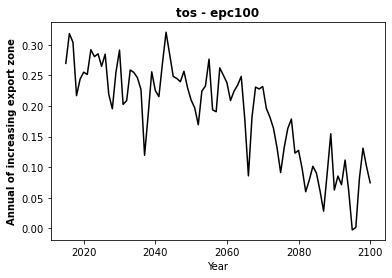

In [22]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc, 'k')
plt.title("{} - epc100".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_annual_inc_correlation.png".format(model, variable, model))

plt.show()

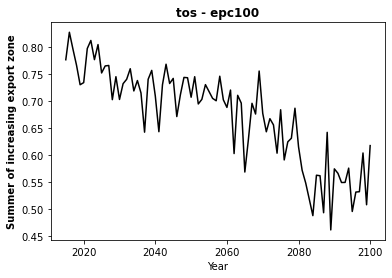

In [23]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc_summer, 'k')
plt.title("{} - epc100".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_summer_inc_correlation.png".format(model, variable, model))

plt.show()

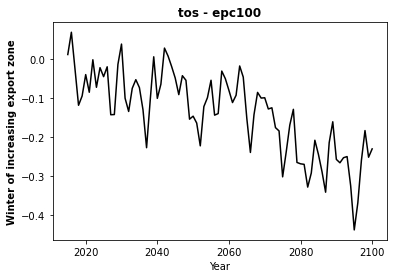

In [24]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc_winter, 'k')
plt.title("{} - epc100".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_winter_inc_correlation.png".format(model, variable, model))

plt.show()

#### Decreasing zone


In [25]:
current_dec = xarray.open_dataarray("Data/{}_{}_{}_dec.nc".format(variable, model, experiment),decode_coords="all")
current_dec

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello']


<xarray.DataArray 'tos' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    units:          degC
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    cell_methods:   area: mean where sea time: mean

In [26]:
epc_dec = xarray.open_dataarray("Data/epc100_{}_{}_dec.nc".format(model, experiment), decode_coords="all")
epc_dec

<xarray.DataArray 'epc100' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    depth        float64 ...
    spatial_ref  int64 ...
Attributes:
    standard_name:  sinking_mole_flux_of_particulate_organic_matter_expressed...
    long_name:      Downward Flux of Particulate Organic Carbon
    units:          mol m-2 s-1
    comment:        The phrase 'expressed_as' is used in the construction A_e...
    original_name:  expc (levid 19)
    cell_methods:   area: mean where sea time: mean
    history:        2021-01-20T13:14:42Z altered by CMOR: Treated scalar dime...

In [27]:
cor_dec = xarray.corr(current_dec, epc_dec, dim = ["lat", "lon"])
cor_dec = cor_dec.groupby("time.year").mean("time")
cor_dec

<xarray.DataArray (year: 86)>
array([-0.07251545, -0.10726485, -0.13251422, -0.19577605, -0.25598333,
       -0.18352368, -0.09077044, -0.0963864 , -0.16381822, -0.18796531,
       -0.16841776, -0.09945848, -0.16460179, -0.24035021, -0.11386195,
       -0.09068082, -0.21476915, -0.20039672, -0.10213406, -0.16120052,
       -0.13189077, -0.17630707, -0.35508774, -0.28901639, -0.22017223,
       -0.21420139, -0.24728429, -0.15578938, -0.08486253, -0.11492351,
       -0.21576109, -0.23995771, -0.14293223, -0.0825737 , -0.20362086,
       -0.2914898 , -0.18997714, -0.19915889, -0.10137092, -0.0749311 ,
       -0.13135188, -0.18043823, -0.23897847, -0.25430179, -0.1693099 ,
       -0.16342711, -0.20635436, -0.22545707, -0.17262145, -0.16021722,
       -0.23043203, -0.29297793, -0.15626076, -0.13864132, -0.11368067,
       -0.22502554, -0.28189129, -0.24978201, -0.24671823, -0.26511607,
       -0.28599166, -0.27933356, -0.18091676, -0.1801806 , -0.22225682,
       -0.30741455, -0.25499545, -0.23521851, -0.24060932, -0.30216163,
       -0.26754681, -0.33562288, -0.29434377, -0.23519104, -0.24257224,
       -0.33614491, -0.33174392, -0.3233079 , -0.25462811, -0.19001417,
       -0.270672  , -0.37229428, -0.29865285, -0.24061157, -0.27553141,
       -0.3059044 ])
Coordinates:
    spatial_ref  int64 0
    depth        float64 100.0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100

In [28]:
time = cor_dec["year"].values

In [29]:
current_dec_season = current_dec.resample(time='QS-DEC').mean(dim="time")
current_dec_season['time']

<xarray.DataArray 'time' (time: 345)>
array([cftime.DatetimeNoLeap(2014, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 2014-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [30]:
current_dec_summer = current_dec_season.sel(time=(current_dec_season.time.dt.month == 12))
current_dec_summer = current_dec_summer.sel(time = slice("2015","2100"))

In [31]:
current_dec_winter = current_dec_season.sel(time=(current_dec_season.time.dt.month == 6))

In [32]:
epc_dec_season = epc_dec.resample(time='QS-DEC').mean(dim="time")

In [33]:
epc_dec_summer = epc_dec_season.sel(time=(epc_dec_season.time.dt.month == 12))
epc_dec_summer = epc_dec_summer.sel(time = slice("2015","2100"))
epc_dec_winter = epc_dec_season.sel(time=(epc_dec_season.time.dt.month == 6))

In [34]:
cor_dec_summer = xarray.corr(current_dec_summer, epc_dec_summer, dim = ["lat", "lon"])
cor_dec_summer

<xarray.DataArray (time: 86)>
array([ 0.4606256 ,  0.38022206,  0.3577478 ,  0.24116751,  0.21468239,
        0.40394325,  0.48107095,  0.48768185,  0.30921259,  0.35301025,
        0.37787983,  0.39410517,  0.25683576,  0.23469456,  0.452715  ,
        0.18058707,  0.18475615,  0.43217074,  0.30311626,  0.25919804,
        0.30255773,  0.05978924, -0.00952825,  0.20879759,  0.39113113,
        0.20043366,  0.22658212,  0.36147157,  0.36816896,  0.25435841,
        0.22571143,  0.20097579,  0.41387819,  0.34969197,  0.1101876 ,
        0.1323542 ,  0.34973183,  0.28554648,  0.30816948,  0.26997201,
        0.25744912,  0.24901616,  0.10078062,  0.3201166 ,  0.17635807,
        0.18280748,  0.17515487,  0.07301905,  0.33114727,  0.23681159,
        0.04224829,  0.27660979,  0.19040128,  0.2244084 ,  0.20425409,
        0.01172837,  0.11260734,  0.02162179,  0.05401592,  0.16109097,
        0.07693459,  0.13403421,  0.12176352,  0.07096868,  0.00905289,
        0.11049493,  0.00776001,  0.05539247, -0.09098379, -0.09461289,
       -0.04796497, -0.03788265,  0.04836537,  0.14779977, -0.09037223,
        0.01051667, -0.08952838, -0.02153121, -0.02744127,  0.08708139,
       -0.10637234, -0.02906059, -0.0581491 ,  0.0429025 ,  0.03100502,
        0.31312089])
Coordinates:
  * time         (time) object 2015-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0
    depth        float64 100.0

In [35]:
cor_dec_winter = xarray.corr(current_dec_winter, epc_dec_winter, dim = ["lat", "lon"])
cor_dec_winter

<xarray.DataArray (time: 86)>
array([-0.36662654, -0.45332456, -0.51879568, -0.53801901, -0.65590231,
       -0.53843889, -0.46371477, -0.4492584 , -0.57115976, -0.55766559,
       -0.53623863, -0.42486756, -0.50893356, -0.57225002, -0.43303542,
       -0.37473583, -0.52907441, -0.55725266, -0.49231157, -0.49023671,
       -0.46865054, -0.51592575, -0.68038285, -0.63098438, -0.58110029,
       -0.57216986, -0.57404583, -0.44962032, -0.4528828 , -0.46819   ,
       -0.5316433 , -0.62209242, -0.48216265, -0.42507313, -0.56481133,
       -0.62450743, -0.5372987 , -0.60145816, -0.45763037, -0.36980805,
       -0.44558005, -0.56327626, -0.62621428, -0.62691112, -0.53207995,
       -0.49069062, -0.57224496, -0.55071303, -0.47304648, -0.51589127,
       -0.62023491, -0.63020894, -0.52093792, -0.46221007, -0.44761172,
       -0.53665944, -0.66568003, -0.58792623, -0.54468405, -0.59667109,
       -0.67604631, -0.62255492, -0.51489128, -0.49217041, -0.56956153,
       -0.69055991, -0.60792877, -0.57348916, -0.54682718, -0.59410558,
       -0.53810562, -0.66742011, -0.61614987, -0.59502126, -0.5829416 ,
       -0.68070944, -0.70471791, -0.64744701, -0.60525283, -0.50844757,
       -0.64177256, -0.73483938, -0.63722385, -0.56492983, -0.64962579,
       -0.63383993])
Coordinates:
  * time         (time) object 2015-06-01 00:00:00 ... 2100-06-01 00:00:00
    spatial_ref  int64 0
    depth        float64 100.0

In [36]:
data = {'Year': time,
        'Annual': cor_dec,
        'Summer': cor_dec_summer,
        'Winter': cor_dec_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,-0.072515,0.460626,-0.366627,CMCC-ESM2
1,2016,-0.107265,0.380222,-0.453325,CMCC-ESM2
2,2017,-0.132514,0.357748,-0.518796,CMCC-ESM2
3,2018,-0.195776,0.241168,-0.538019,CMCC-ESM2
4,2019,-0.255983,0.214682,-0.655902,CMCC-ESM2
...,...,...,...,...,...
81,2096,-0.372294,-0.029061,-0.734839,CMCC-ESM2
82,2097,-0.298653,-0.058149,-0.637224,CMCC-ESM2
83,2098,-0.240612,0.042903,-0.564930,CMCC-ESM2
84,2099,-0.275531,0.031005,-0.649626,CMCC-ESM2


In [37]:
df.to_csv("csv/{}_{}_epc100_correlation_dec.csv".format(model, variable), index = False, header=True)

In [38]:
dec_mean = np.nanmean(cor_dec.values)
dec_mean_summer = np.nanmean(cor_dec_summer.values)
dec_mean_winter = np.nanmean(cor_dec_winter.values)

dec_max = np.nanmax(cor_dec.values)
dec_max_summer = np.nanmax(cor_dec_summer.values)
dec_max_winter = np.nanmax(cor_dec_winter.values)

dec_min = np.nanmin(cor_dec.values)
dec_min_summer = np.nanmin(cor_dec_summer.values)
dec_min_winter = np.nanmin(cor_dec_winter.values)

In [39]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nSpatial correlation with epc100 in decreasing zone:\n")
summary.write("Annual mean: {}\nAnnual max: {}\nAnnual min: {}".format(dec_mean, dec_max, dec_min))
summary.write("\n\nSummer mean: {}\nSummer max: {}\nSummer min: {}".format(dec_mean_summer, dec_max_summer, dec_min_summer))
summary.write("\n\nWinter mean: {}\nWinter max: {}\nWinter min: {}".format(dec_mean_winter, dec_max_winter, dec_min_winter))
summary.close()

#### Plotting

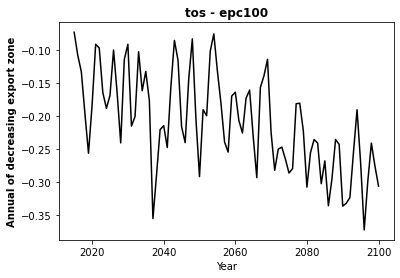

In [40]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec, 'k')
plt.title("{} - epc100".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_annual_dec_correlation.png".format(model, variable, model))

plt.show()

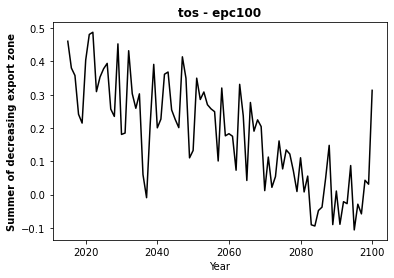

In [41]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec_summer, 'k')
plt.title("{} - epc100".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_summer_dec_correlation.png".format(model, variable, model))

plt.show()

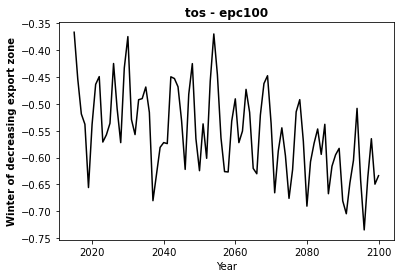

In [42]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec_winter, 'k')
plt.title("{} - epc100".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_winter_dec_correlation.png".format(model, variable, model))

plt.show()

## Correlation with intpp

### 20 year change correlation

#### Percentage

In [43]:
current_inc_per = xarray.open_dataarray("Data/{}_{}_{}_percentage.nc".format(variable, model, experiment))
other_inc_per = xarray.open_dataarray("Data/intpp_{}_{}_percentage.nc".format(model, experiment))

In [44]:
cor_per = xarray.corr(current_inc_per, other_inc_per, dim = ["lat", "lon"])
cor_per

<xarray.DataArray ()>
array(0.00235935)

In [45]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nPercentage correlation with intpp: {}".format(cor_per.values))
summary.close()

#### Absolute

In [46]:
current_inc_abs = xarray.open_dataarray("Data/{}_{}_{}_absolute.nc".format(variable, model, experiment))
other_inc_abs = xarray.open_dataarray("Data/intpp_{}_{}_absolute.nc".format(model, experiment))

In [47]:
cor_abs = xarray.corr(current_inc_abs, other_inc_abs, dim = ["lat", "lon"])
cor_abs

<xarray.DataArray ()>
array(-0.20357366)

In [48]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\nAbsolute correlation with intpp: {}".format(cor_abs.values))
summary.close()

### Spatial correlation 

#### Increasing zone


In [6]:
current_inc = xarray.open_dataarray("Data/{}_{}_{}_inc.nc".format(variable, model, experiment),decode_coords="all")
current_inc

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello']


<xarray.DataArray 'tos' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    units:          degC
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    cell_methods:   area: mean where sea time: mean

In [7]:
epc = xarray.open_dataarray("Data/intpp_{}_{}_inc.nc".format(model, experiment), decode_coords="all")
epc

<xarray.DataArray 'intpp' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  net_primary_mole_productivity_of_biomass_expressed_as_car...
    long_name:      Primary Organic Carbon Production by All Types of Phytopl...
    units:          mol m-2 s-1
    comment:        Vertically integrated total primary (organic carbon) prod...
    original_name:  pp
    cell_methods:   area: mean where sea depth: sum where sea time: mean
    history:        2021-01-20T13:15:10Z altered by CMOR: Converted type from...

In [8]:
cor_inc = xarray.corr(current_inc, epc, dim = ["lat", "lon"])
cor_inc = cor_inc.groupby("time.year").mean("time")
cor_inc

<xarray.DataArray (year: 86)>
array([0.47756128, 0.45228419, 0.45864017, 0.40643722, 0.39188979,
       0.44407485, 0.45334216, 0.47834239, 0.4705678 , 0.4795492 ,
       0.43224182, 0.43154467, 0.41564612, 0.35174867, 0.42626526,
       0.44143863, 0.36670027, 0.37219102, 0.42681084, 0.44996817,
       0.42834091, 0.41187857, 0.32618539, 0.38523376, 0.44783583,
       0.39510704, 0.34804756, 0.46838558, 0.46633911, 0.44490555,
       0.40845596, 0.39331689, 0.43915372, 0.44192399, 0.41109957,
       0.36572226, 0.40813991, 0.36250139, 0.435866  , 0.43412781,
       0.41081711, 0.41108628, 0.38932532, 0.44074321, 0.40439642,
       0.43030038, 0.42971012, 0.40547313, 0.46993056, 0.43658171,
       0.39643683, 0.38125709, 0.38396225, 0.43856774, 0.46735289,
       0.427415  , 0.41254714, 0.41918286, 0.4025081 , 0.38259453,
       0.39739871, 0.37701364, 0.41001992, 0.4219159 , 0.39866252,
       0.38944265, 0.35396304, 0.38437137, 0.36723118, 0.37869255,
       0.37318902, 0.33183536, 0.32571836, 0.34114213, 0.38605072,
       0.40226676, 0.36444047, 0.37477161, 0.36628423, 0.38653413,
       0.36046487, 0.32927401, 0.35481138, 0.39905203, 0.40026195,
       0.37721429])
Coordinates:
    spatial_ref  int64 0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100

In [9]:
time = cor_inc["year"].values

In [10]:
current_inc_season = current_inc.resample(time='QS-DEC').mean(dim="time")
current_inc_season['time']

<xarray.DataArray 'time' (time: 345)>
array([cftime.DatetimeNoLeap(2014, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 2014-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [11]:
current_inc_summer = current_inc_season.sel(time=(current_inc_season.time.dt.month == 12))
current_inc_summer = current_inc_summer.sel(time = slice("2015","2100"))

In [12]:
current_inc_winter = current_inc_season.sel(time=(current_inc_season.time.dt.month == 6))

In [13]:
epc_inc_season = epc.resample(time='QS-DEC').mean(dim="time")

In [14]:
epc_inc_summer = epc_inc_season.sel(time=(epc_inc_season.time.dt.month == 12))
epc_inc_summer = epc_inc_summer.sel(time = slice("2015","2100"))
epc_inc_winter = epc_inc_season.sel(time=(epc_inc_season.time.dt.month == 6))

In [15]:
cor_inc_summer = xarray.corr(current_inc_summer, epc_inc_summer, dim = ["lat", "lon"])
cor_inc_summer

<xarray.DataArray (time: 86)>
array([ 0.25672947,  0.17698292, -0.04966239,  0.19086882,  0.06353795,
        0.07643064,  0.10399865,  0.12886005,  0.17009552,  0.12359358,
        0.11849828, -0.00849469,  0.00463705,  0.1038065 ,  0.18982952,
        0.01843397, -0.05380776, -0.0413743 ,  0.13325087,  0.0932788 ,
        0.15549862, -0.09767462, -0.05030148,  0.05810292,  0.05219575,
       -0.01836673,  0.14081692,  0.15775628,  0.10516605,  0.1154523 ,
       -0.01436748,  0.01519374,  0.01765983,  0.0579916 ,  0.03333441,
       -0.04682008, -0.13522195, -0.09503536, -0.02788453,  0.04056006,
       -0.07898058, -0.05331559,  0.0221094 , -0.09483575, -0.0914816 ,
       -0.04757768, -0.03608146,  0.07145016,  0.02022514, -0.08810701,
       -0.12650657, -0.07119239, -0.03805818,  0.00286936,  0.05264938,
        0.0798933 , -0.12006099, -0.15031876, -0.07083822, -0.13093512,
       -0.05311833, -0.09215583, -0.10107958, -0.05887403, -0.02305035,
       -0.21061718, -0.27810287, -0.14265229, -0.14627849, -0.20055751,
       -0.20762412, -0.26663671, -0.18856594, -0.13472531, -0.11650957,
       -0.11675595, -0.16150264, -0.11084658, -0.21954555, -0.22657049,
       -0.25299354, -0.13775725, -0.16580908, -0.15635076, -0.11147383,
       -0.2449955 ])
Coordinates:
  * time         (time) object 2015-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [16]:
cor_inc_winter = xarray.corr(current_inc_winter, epc_inc_winter, dim = ["lat", "lon"])
cor_inc_winter

<xarray.DataArray (time: 86)>
array([0.76062779, 0.72350415, 0.80284889, 0.75290751, 0.64088747,
       0.75627253, 0.77679795, 0.79604408, 0.8246594 , 0.76218613,
       0.70531175, 0.78424539, 0.74892889, 0.57573388, 0.72469924,
       0.72330328, 0.6393195 , 0.69205034, 0.78638474, 0.75785839,
       0.75549786, 0.76875679, 0.57657888, 0.70605631, 0.73843046,
       0.73679809, 0.60860282, 0.77699166, 0.80932057, 0.76983178,
       0.70362202, 0.72988216, 0.74966563, 0.78886902, 0.72269036,
       0.67518714, 0.7231872 , 0.72072011, 0.76836009, 0.7712972 ,
       0.76759815, 0.74180483, 0.68244548, 0.76366462, 0.76749076,
       0.78854975, 0.76523115, 0.72113425, 0.78655077, 0.77457435,
       0.76730208, 0.67755285, 0.76740535, 0.79256418, 0.80275008,
       0.73068579, 0.69467657, 0.77792801, 0.75514269, 0.66883762,
       0.69586965, 0.67411735, 0.74024663, 0.78448966, 0.72772663,
       0.68660901, 0.71505816, 0.74592753, 0.71775514, 0.7308741 ,
       0.77360025, 0.66972158, 0.65092327, 0.71017852, 0.74953652,
       0.74888269, 0.73204092, 0.7445355 , 0.73599978, 0.75394273,
       0.75038701, 0.71236887, 0.72469521, 0.77781083, 0.73987416,
       0.70795291])
Coordinates:
  * time         (time) object 2015-06-01 00:00:00 ... 2100-06-01 00:00:00
    spatial_ref  int64 0

In [17]:
data = {'Year': time,
        'Annual': cor_inc,
        'Summer': cor_inc_summer,
        'Winter': cor_inc_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,0.477561,0.256729,0.760628,CMCC-ESM2
1,2016,0.452284,0.176983,0.723504,CMCC-ESM2
2,2017,0.458640,-0.049662,0.802849,CMCC-ESM2
3,2018,0.406437,0.190869,0.752908,CMCC-ESM2
4,2019,0.391890,0.063538,0.640887,CMCC-ESM2
...,...,...,...,...,...
81,2096,0.329274,-0.137757,0.712369,CMCC-ESM2
82,2097,0.354811,-0.165809,0.724695,CMCC-ESM2
83,2098,0.399052,-0.156351,0.777811,CMCC-ESM2
84,2099,0.400262,-0.111474,0.739874,CMCC-ESM2


In [18]:
df.to_csv("csv/{}_{}_intpp_correlation_inc.csv".format(model, variable), index = False, header=True)

In [19]:
inc_mean = np.nanmean(cor_inc.values)
inc_mean_summer = np.nanmean(cor_inc_summer.values)
inc_mean_winter = np.nanmean(cor_inc_winter.values)

inc_max = np.nanmax(cor_inc.values)
inc_max_summer = np.nanmax(cor_inc_summer.values)
inc_max_winter = np.nanmax(cor_inc_winter.values)

inc_min = np.nanmin(cor_inc.values)
inc_min_summer = np.nanmin(cor_inc_summer.values)
inc_min_winter = np.nanmin(cor_inc_winter.values)

In [20]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nSpatial correlation with intpp in increasing zone:\n")
summary.write("Annual mean: {}\nAnnual max: {}\nAnnual min: {}".format(inc_mean, inc_max, inc_min))
summary.write("\n\nSummer mean: {}\nSummer max: {}\nSummer min: {}".format(inc_mean_summer, inc_max_summer, inc_min_summer))
summary.write("\n\nWinter mean: {}\nWinter max: {}\nWinter min: {}".format(inc_mean_winter, inc_max_winter, inc_min_winter))
summary.close()

#### Plotting

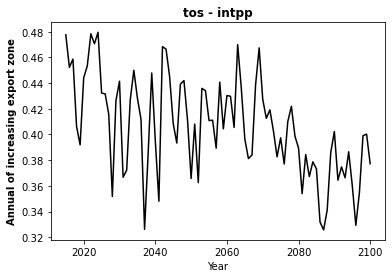

In [21]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc, 'k')
plt.title("{} - intpp".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_intpp_{}_annual_inc_correlation.png".format(model, variable, model))

plt.show()

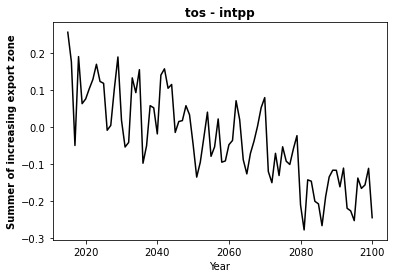

In [22]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc_summer, 'k')
plt.title("{} - intpp".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_intpp_{}_summer_inc_correlation.png".format(model, variable, model))

plt.show()

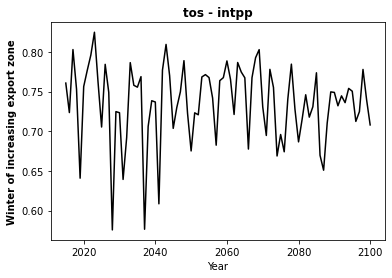

In [23]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc_winter, 'k')
plt.title("{} - intpp".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_intpp_{}_winter_inc_correlation.png".format(model, variable, model))

plt.show()

#### Decreasing zone


In [24]:
current_dec = xarray.open_dataarray("Data/{}_{}_{}_dec.nc".format(variable, model, experiment),decode_coords="all")
current_dec

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello']


<xarray.DataArray 'tos' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    units:          degC
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    cell_methods:   area: mean where sea time: mean

In [25]:
epc_dec = xarray.open_dataarray("Data/intpp_{}_{}_dec.nc".format(model, experiment), decode_coords="all")
epc_dec

<xarray.DataArray 'intpp' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  net_primary_mole_productivity_of_biomass_expressed_as_car...
    long_name:      Primary Organic Carbon Production by All Types of Phytopl...
    units:          mol m-2 s-1
    comment:        Vertically integrated total primary (organic carbon) prod...
    original_name:  pp
    cell_methods:   area: mean where sea depth: sum where sea time: mean
    history:        2021-01-20T13:15:10Z altered by CMOR: Converted type from...

In [26]:
cor_dec = xarray.corr(current_dec, epc_dec, dim = ["lat", "lon"])
cor_dec = cor_dec.groupby("time.year").mean("time")
cor_dec

<xarray.DataArray (year: 86)>
array([0.30119263, 0.25291362, 0.23630142, 0.1894253 , 0.15408379,
       0.29398719, 0.32642924, 0.27770679, 0.24357886, 0.21806398,
       0.18602564, 0.21354392, 0.17342815, 0.11723134, 0.24322961,
       0.21649576, 0.12803512, 0.20708425, 0.26186018, 0.26484032,
       0.26286189, 0.20557755, 0.04978766, 0.16357451, 0.25043318,
       0.21626906, 0.13708479, 0.29559155, 0.29118621, 0.2216124 ,
       0.13406353, 0.17087789, 0.28751812, 0.32412936, 0.18986304,
       0.11769218, 0.18147569, 0.17994925, 0.26444401, 0.28194402,
       0.23335175, 0.22189379, 0.16883843, 0.19649058, 0.21905407,
       0.26143444, 0.25748225, 0.22956802, 0.26145396, 0.27421361,
       0.19772104, 0.17420896, 0.2659443 , 0.28790605, 0.29675603,
       0.22336301, 0.17307236, 0.21013882, 0.23792268, 0.19553355,
       0.1804523 , 0.18872344, 0.22978315, 0.26029483, 0.25615227,
       0.20608677, 0.19939724, 0.23261739, 0.20556331, 0.18334979,
       0.20459659, 0.15311071, 0.18867753, 0.19145179, 0.22446275,
       0.21905841, 0.19150998, 0.19574233, 0.2208926 , 0.27747929,
       0.21349505, 0.15251834, 0.20155803, 0.22275057, 0.23252665,
       0.19049485])
Coordinates:
    spatial_ref  int64 0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100

In [27]:
time = cor_dec["year"].values

In [28]:
current_dec_season = current_dec.resample(time='QS-DEC').mean(dim="time")
current_dec_season['time']

<xarray.DataArray 'time' (time: 345)>
array([cftime.DatetimeNoLeap(2014, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 2014-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [29]:
current_dec_summer = current_dec_season.sel(time=(current_dec_season.time.dt.month == 12))
current_dec_summer = current_dec_summer.sel(time = slice("2015","2100"))

In [30]:
current_dec_winter = current_dec_season.sel(time=(current_dec_season.time.dt.month == 6))

In [31]:
epc_dec_season = epc_dec.resample(time='QS-DEC').mean(dim="time")

In [32]:
epc_dec_summer = epc_dec_season.sel(time=(epc_dec_season.time.dt.month == 12))
epc_dec_summer = epc_dec_summer.sel(time = slice("2015","2100"))
epc_dec_winter = epc_dec_season.sel(time=(epc_dec_season.time.dt.month == 6))

In [33]:
cor_dec_summer = xarray.corr(current_dec_summer, epc_dec_summer, dim = ["lat", "lon"])
cor_dec_summer

<xarray.DataArray (time: 86)>
array([-0.01887954,  0.01166829, -0.16295869, -0.16354571, -0.18304202,
        0.00289835, -0.04726021, -0.11764894, -0.0245967 , -0.10520738,
       -0.10478988, -0.1969342 , -0.20964063, -0.12262834, -0.02108919,
       -0.18021683, -0.22430398, -0.1517039 , -0.09326954, -0.03101312,
       -0.08830786, -0.29967802, -0.28179785, -0.16313179, -0.06670224,
       -0.14036663, -0.08322799, -0.01542301, -0.04154181, -0.260194  ,
       -0.25547338, -0.06913141, -0.05151384, -0.1016832 , -0.2902623 ,
       -0.25403123, -0.26608638, -0.18710742, -0.16799415, -0.12277722,
       -0.07382024, -0.18391458, -0.23803296, -0.29950303, -0.17934119,
       -0.15480046, -0.16251471, -0.2134277 , -0.10033125, -0.1252436 ,
       -0.30169388, -0.14878521, -0.21896976, -0.16909944, -0.16864383,
       -0.22767399, -0.38688973, -0.28088046, -0.27048903, -0.30653701,
       -0.26282089, -0.23967546, -0.23059011, -0.16383479, -0.26670961,
       -0.31676278, -0.33434816, -0.27085159, -0.37769135, -0.32588859,
       -0.36058331, -0.32649583, -0.355566  , -0.40867227, -0.31972386,
       -0.36515412, -0.43754844, -0.37736799, -0.2484887 , -0.29391518,
       -0.49805561, -0.39806392, -0.34635329, -0.42033889, -0.32200022,
       -0.46671337])
Coordinates:
  * time         (time) object 2015-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [34]:
cor_dec_winter = xarray.corr(current_dec_winter, epc_dec_winter, dim = ["lat", "lon"])
cor_dec_winter

<xarray.DataArray (time: 86)>
array([0.6277253 , 0.54606979, 0.55301157, 0.47707374, 0.42905762,
       0.63859709, 0.6799778 , 0.64067311, 0.64493363, 0.49525865,
       0.44224356, 0.48110889, 0.44337619, 0.29812847, 0.53195572,
       0.50048716, 0.34392312, 0.52209484, 0.62015543, 0.56295376,
       0.60717228, 0.54409606, 0.24513351, 0.45778991, 0.57345859,
       0.51599812, 0.38830465, 0.7028111 , 0.64986871, 0.56900721,
       0.38188167, 0.48821196, 0.65104498, 0.70858447, 0.51195479,
       0.40992259, 0.51261893, 0.53390843, 0.62229159, 0.63506658,
       0.55884796, 0.52721819, 0.4720766 , 0.58541463, 0.64321411,
       0.66455319, 0.60134034, 0.59544514, 0.67324994, 0.69036659,
       0.56813331, 0.51058184, 0.68365823, 0.69391197, 0.6977417 ,
       0.57967781, 0.51733163, 0.6449667 , 0.65535608, 0.5691869 ,
       0.50604959, 0.54611418, 0.6485146 , 0.70356964, 0.67444147,
       0.58183666, 0.65423864, 0.62300395, 0.58633505, 0.63858522,
       0.68156802, 0.59421855, 0.54781242, 0.64682819, 0.70637793,
       0.66962217, 0.64005259, 0.64576709, 0.65599879, 0.70922408,
       0.66169598, 0.65469254, 0.7009274 , 0.68962764, 0.66594506,
       0.64515735])
Coordinates:
  * time         (time) object 2015-06-01 00:00:00 ... 2100-06-01 00:00:00
    spatial_ref  int64 0

In [35]:
data = {'Year': time,
        'Annual': cor_dec,
        'Summer': cor_dec_summer,
        'Winter': cor_dec_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,0.301193,-0.018880,0.627725,CMCC-ESM2
1,2016,0.252914,0.011668,0.546070,CMCC-ESM2
2,2017,0.236301,-0.162959,0.553012,CMCC-ESM2
3,2018,0.189425,-0.163546,0.477074,CMCC-ESM2
4,2019,0.154084,-0.183042,0.429058,CMCC-ESM2
...,...,...,...,...,...
81,2096,0.152518,-0.398064,0.654693,CMCC-ESM2
82,2097,0.201558,-0.346353,0.700927,CMCC-ESM2
83,2098,0.222751,-0.420339,0.689628,CMCC-ESM2
84,2099,0.232527,-0.322000,0.665945,CMCC-ESM2


In [36]:
df.to_csv("csv/{}_{}_intpp_correlation_dec.csv".format(model, variable), index = False, header=True)

In [37]:
dec_mean = np.nanmean(cor_dec.values)
dec_mean_summer = np.nanmean(cor_dec_summer.values)
dec_mean_winter = np.nanmean(cor_dec_winter.values)

dec_max = np.nanmax(cor_dec.values)
dec_max_summer = np.nanmax(cor_dec_summer.values)
dec_max_winter = np.nanmax(cor_dec_winter.values)

dec_min = np.nanmin(cor_dec.values)
dec_min_summer = np.nanmin(cor_dec_summer.values)
dec_min_winter = np.nanmin(cor_dec_winter.values)

In [38]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nSpatial correlation with intpp in decreasing zone:\n")
summary.write("Annual mean: {}\nAnnual max: {}\nAnnual min: {}".format(dec_mean, dec_max, dec_min))
summary.write("\n\nSummer mean: {}\nSummer max: {}\nSummer min: {}".format(dec_mean_summer, dec_max_summer, dec_min_summer))
summary.write("\n\nWinter mean: {}\nWinter max: {}\nWinter min: {}".format(dec_mean_winter, dec_max_winter, dec_min_winter))
summary.close()

#### Plotting

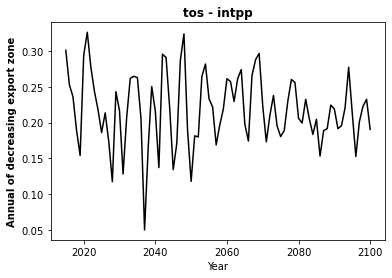

In [39]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec, 'k')
plt.title("{} - intpp".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_intpp_{}_annual_dec_correlation.png".format(model, variable, model))

plt.show()

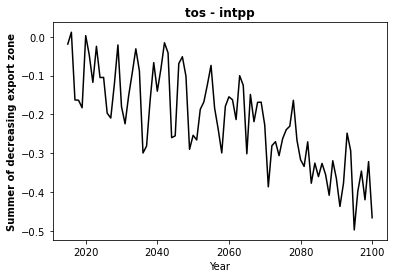

In [40]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec_summer, 'k')
plt.title("{} - intpp".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_intpp_{}_summer_dec_correlation.png".format(model, variable, model))

plt.show()

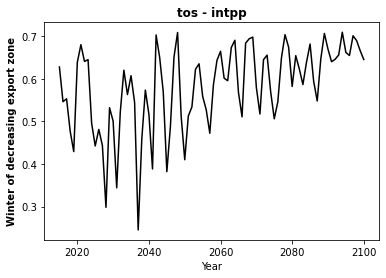

In [41]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec_winter, 'k')
plt.title("{} - intpp".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_intpp_{}_winter_dec_correlation.png".format(model, variable, model))

plt.show()

## Correlation with siconc

### 20 year change correlation

#### Percentage

In [6]:
current_inc_per = xarray.open_dataarray("Data/{}_{}_{}_percentage.nc".format(variable, model, experiment))
other_inc_per = xarray.open_dataarray("Data/siconc_{}_{}_percentage.nc".format(model, experiment))

In [7]:
cor_per = xarray.corr(current_inc_per, other_inc_per, dim = ["lat", "lon"])
cor_per

<xarray.DataArray ()>
array(0.01938468)

In [8]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nPercentage correlation with siconc: {}".format(cor_per.values))
summary.close()

#### Absolute

In [9]:
current_inc_abs = xarray.open_dataarray("Data/{}_{}_{}_absolute.nc".format(variable, model, experiment))
other_inc_abs = xarray.open_dataarray("Data/siconc_{}_{}_absolute.nc".format(model, experiment))

In [10]:
cor_abs = xarray.corr(current_inc_abs, other_inc_abs, dim = ["lat", "lon"])
cor_abs

<xarray.DataArray ()>
array(-0.0656083)

In [11]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\nAbsolute correlation with siconc: {}".format(cor_abs.values))
summary.close()

### Spatial correlation 

#### Increasing zone


In [12]:
current_inc = xarray.open_dataarray("Data/{}_{}_{}_inc.nc".format(variable, model, experiment),decode_coords="all")
current_inc

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello']


<xarray.DataArray 'tos' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    units:          degC
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    cell_methods:   area: mean where sea time: mean

In [13]:
epc = xarray.open_dataarray("Data/siconc_{}_{}_inc.nc".format(model, experiment), decode_coords="all")
epc

<xarray.DataArray 'siconc' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  sea_ice_area_fraction
    long_name:      Sea-Ice Area Percentage (Ocean Grid)
    units:          %
    comment:        Percentage of grid cell covered by sea ice
    original_name:  aice
    cell_methods:   area: mean where sea time: mean
    history:        2021-01-19T23:30:29Z altered by CMOR: Treated scalar dime...

In [14]:
cor_inc = xarray.corr(current_inc, epc, dim = ["lat", "lon"])
cor_inc = cor_inc.groupby("time.year").mean("time")
cor_inc

<xarray.DataArray (year: 86)>
array([-0.75236852, -0.76824218, -0.76195407, -0.76405276, -0.77029687,
       -0.73470266, -0.74302661, -0.7450387 , -0.74879497, -0.74855285,
       -0.76751793, -0.74547516, -0.76976486, -0.7475702 , -0.74291536,
       -0.76855685, -0.74753421, -0.73291727, -0.75319963, -0.75349197,
       -0.73656548, -0.74641708, -0.74789748, -0.72577777, -0.73636015,
       -0.750195  , -0.7344682 , -0.71516246, -0.73949584, -0.73702391,
       -0.75564661, -0.75057216, -0.71075678, -0.72117599, -0.74444539,
       -0.73861278, -0.71714801, -0.75824787, -0.71318281, -0.71849413,
       -0.71489029, -0.70352549, -0.73606055, -0.72305044, -0.71294769,
       -0.69591742, -0.69243905, -0.71492484, -0.69936873, -0.71145629,
       -0.71844616, -0.70360188, -0.71826133, -0.70599134, -0.6896923 ,
       -0.70230619, -0.70088078, -0.68802622, -0.68434417, -0.69452398,
       -0.66272588, -0.70229316, -0.68110608, -0.68207061, -0.67576924,
       -0.67668445, -0.67554862, -0.66306576, -0.67227533, -0.64636048,
       -0.64341985, -0.6735474 , -0.63488203, -0.68091244, -0.65885655,
       -0.63211024, -0.64725949, -0.63982951, -0.65193273, -0.63372085,
       -0.63415818, -0.64355229, -0.65764807, -0.61601446, -0.64308881,
       -0.62801809])
Coordinates:
    spatial_ref  int64 0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100

In [15]:
time = cor_inc["year"].values

In [16]:
current_inc_season = current_inc.resample(time='QS-DEC').mean(dim="time")
current_inc_season['time']

<xarray.DataArray 'time' (time: 345)>
array([cftime.DatetimeNoLeap(2014, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 2014-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [17]:
current_inc_summer = current_inc_season.sel(time=(current_inc_season.time.dt.month == 12))
current_inc_summer = current_inc_summer.sel(time = slice("2015","2100"))

In [18]:
current_inc_winter = current_inc_season.sel(time=(current_inc_season.time.dt.month == 6))

In [19]:
epc_inc_season = epc.resample(time='QS-DEC').mean(dim="time")

In [20]:
epc_inc_summer = epc_inc_season.sel(time=(epc_inc_season.time.dt.month == 12))
epc_inc_summer = epc_inc_summer.sel(time = slice("2015","2100"))
epc_inc_winter = epc_inc_season.sel(time=(epc_inc_season.time.dt.month == 6))

In [21]:
cor_inc_summer = xarray.corr(current_inc_summer, epc_inc_summer, dim = ["lat", "lon"])
cor_inc_summer

<xarray.DataArray (time: 86)>
array([-0.87916578, -0.87782922, -0.86901754, -0.8541037 , -0.84963465,
       -0.84929164, -0.88027592, -0.86700184, -0.84301405, -0.86517811,
       -0.851913  , -0.87413942, -0.8754385 , -0.85609767, -0.85180676,
       -0.82883324, -0.85136045, -0.84714547, -0.87122883, -0.86059711,
       -0.84344377, -0.82251133, -0.81756483, -0.83575358, -0.84737297,
       -0.8325462 , -0.80521976, -0.85128834, -0.84989504, -0.85512795,
       -0.86278843, -0.81878101, -0.82772576, -0.84990153, -0.86058935,
       -0.80554794, -0.85370306, -0.82922644, -0.82913636, -0.8293863 ,
       -0.81653141, -0.8198657 , -0.82762443, -0.80914639, -0.83256544,
       -0.8034041 , -0.81320112, -0.78653946, -0.80568071, -0.7787739 ,
       -0.77499827, -0.80914141, -0.81030659, -0.77831987, -0.79488124,
       -0.76632024, -0.80992666, -0.79655503, -0.76338764, -0.77255232,
       -0.77362262, -0.75817935, -0.81098858, -0.76433001, -0.78080186,
       -0.76241659, -0.73657979, -0.7416813 , -0.73551984, -0.70374079,
       -0.73913571, -0.71120362, -0.7144494 , -0.77377177, -0.62694057,
       -0.71697718, -0.73734613, -0.73558445, -0.67978245, -0.73703683,
       -0.70464237, -0.69561609, -0.71871542, -0.73896627, -0.70576162,
       -0.75069414])
Coordinates:
  * time         (time) object 2015-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [22]:
cor_inc_winter = xarray.corr(current_inc_winter, epc_inc_winter, dim = ["lat", "lon"])
cor_inc_winter

<xarray.DataArray (time: 86)>
array([-0.85743918, -0.86096768, -0.86031482, -0.87172606, -0.86046877,
       -0.8361683 , -0.84067591, -0.85580834, -0.85614585, -0.86650987,
       -0.85894452, -0.86255183, -0.8602788 , -0.83524718, -0.85519146,
       -0.86251376, -0.85381445, -0.86222281, -0.86453352, -0.85852755,
       -0.84738092, -0.85666729, -0.84327899, -0.85930613, -0.86684333,
       -0.86417532, -0.84282304, -0.85159728, -0.8550518 , -0.8483839 ,
       -0.84587535, -0.86111839, -0.85548526, -0.85648229, -0.84880721,
       -0.8509679 , -0.84704399, -0.86228612, -0.85963506, -0.85398658,
       -0.84620201, -0.83695652, -0.83412561, -0.85364746, -0.84099779,
       -0.8438383 , -0.84235387, -0.85374283, -0.84430393, -0.84063203,
       -0.84008814, -0.83707838, -0.85414222, -0.84438516, -0.84537963,
       -0.83841022, -0.81931689, -0.83958803, -0.83112377, -0.84351025,
       -0.8214214 , -0.84290557, -0.83038087, -0.83666669, -0.8320439 ,
       -0.82624103, -0.81895068, -0.8190098 , -0.83153106, -0.82206155,
       -0.82216924, -0.82617542, -0.8277122 , -0.83599921, -0.83811153,
       -0.82237668, -0.81811223, -0.82568377, -0.81131845, -0.82357694,
       -0.8176693 , -0.82297201, -0.81844147, -0.81725475, -0.80753794,
       -0.82004943])
Coordinates:
  * time         (time) object 2015-06-01 00:00:00 ... 2100-06-01 00:00:00
    spatial_ref  int64 0

In [23]:
data = {'Year': time,
        'Annual': cor_inc,
        'Summer': cor_inc_summer,
        'Winter': cor_inc_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,-0.752369,-0.879166,-0.857439,CMCC-ESM2
1,2016,-0.768242,-0.877829,-0.860968,CMCC-ESM2
2,2017,-0.761954,-0.869018,-0.860315,CMCC-ESM2
3,2018,-0.764053,-0.854104,-0.871726,CMCC-ESM2
4,2019,-0.770297,-0.849635,-0.860469,CMCC-ESM2
...,...,...,...,...,...
81,2096,-0.643552,-0.695616,-0.822972,CMCC-ESM2
82,2097,-0.657648,-0.718715,-0.818441,CMCC-ESM2
83,2098,-0.616014,-0.738966,-0.817255,CMCC-ESM2
84,2099,-0.643089,-0.705762,-0.807538,CMCC-ESM2


In [24]:
df.to_csv("csv/{}_{}_siconc_correlation_inc.csv".format(model, variable), index = False, header=True)

In [25]:
inc_mean = np.nanmean(cor_inc.values)
inc_mean_summer = np.nanmean(cor_inc_summer.values)
inc_mean_winter = np.nanmean(cor_inc_winter.values)

inc_max = np.nanmax(cor_inc.values)
inc_max_summer = np.nanmax(cor_inc_summer.values)
inc_max_winter = np.nanmax(cor_inc_winter.values)

inc_min = np.nanmin(cor_inc.values)
inc_min_summer = np.nanmin(cor_inc_summer.values)
inc_min_winter = np.nanmin(cor_inc_winter.values)

In [26]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nSpatial correlation with siconc in increasing zone:\n")
summary.write("Annual mean: {}\nAnnual max: {}\nAnnual min: {}".format(inc_mean, inc_max, inc_min))
summary.write("\n\nSummer mean: {}\nSummer max: {}\nSummer min: {}".format(inc_mean_summer, inc_max_summer, inc_min_summer))
summary.write("\n\nWinter mean: {}\nWinter max: {}\nWinter min: {}".format(inc_mean_winter, inc_max_winter, inc_min_winter))
summary.close()

#### Plotting

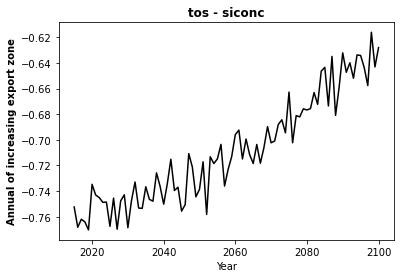

In [27]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc, 'k')
plt.title("{} - siconc".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_siconc_{}_annual_inc_correlation.png".format(model, variable, model))

plt.show()

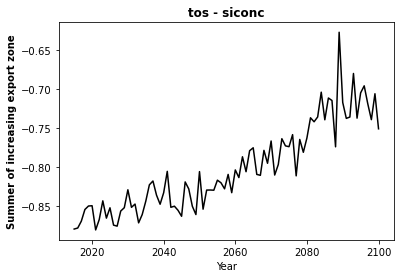

In [28]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc_summer, 'k')
plt.title("{} - siconc".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_siconc_{}_summer_inc_correlation.png".format(model, variable, model))

plt.show()

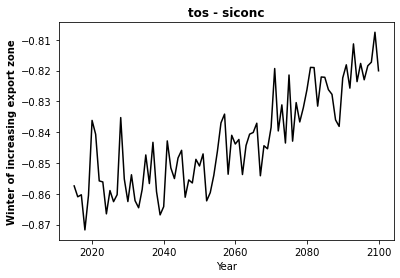

In [29]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc_winter, 'k')
plt.title("{} - siconc".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_siconc_{}_winter_inc_correlation.png".format(model, variable, model))

plt.show()

#### Decreasing zone


In [30]:
current_dec = xarray.open_dataarray("Data/{}_{}_{}_dec.nc".format(variable, model, experiment),decode_coords="all")
current_dec

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello']


<xarray.DataArray 'tos' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    units:          degC
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    cell_methods:   area: mean where sea time: mean

In [31]:
epc_dec = xarray.open_dataarray("Data/siconc_{}_{}_dec.nc".format(model, experiment), decode_coords="all")
epc_dec

<xarray.DataArray 'siconc' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  sea_ice_area_fraction
    long_name:      Sea-Ice Area Percentage (Ocean Grid)
    units:          %
    comment:        Percentage of grid cell covered by sea ice
    original_name:  aice
    cell_methods:   area: mean where sea time: mean
    history:        2021-01-19T23:30:29Z altered by CMOR: Treated scalar dime...

In [32]:
cor_dec = xarray.corr(current_dec, epc_dec, dim = ["lat", "lon"])
cor_dec = cor_dec.groupby("time.year").mean("time")
cor_dec

<xarray.DataArray (year: 86)>
array([-0.67317789, -0.69107964, -0.69865564, -0.73923417, -0.69584734,
       -0.67559316, -0.72775185, -0.72868117, -0.71225634, -0.67926626,
       -0.70485007, -0.6768015 , -0.72196265, -0.69087765, -0.69771655,
       -0.71671471, -0.69099905, -0.69036868, -0.72852336, -0.69494305,
       -0.7108864 , -0.69722299, -0.66915244, -0.65915509, -0.68967154,
       -0.72179051, -0.68712727, -0.68263756, -0.71194503, -0.71714663,
       -0.73048114, -0.71612219, -0.69280228, -0.70618227, -0.70854696,
       -0.68144199, -0.66452367, -0.72056128, -0.68651522, -0.69500534,
       -0.69205798, -0.69347257, -0.7048369 , -0.69179743, -0.70243547,
       -0.67571582, -0.6734658 , -0.68813307, -0.67888574, -0.7101594 ,
       -0.70434496, -0.69306571, -0.7248796 , -0.68288535, -0.65456335,
       -0.66512669, -0.66208426, -0.69151974, -0.68147111, -0.68475566,
       -0.67889167, -0.68309743, -0.68165497, -0.65488545, -0.64811868,
       -0.66518968, -0.67262934, -0.67618744, -0.65495894, -0.63407476,
       -0.66739159, -0.6576849 , -0.63530126, -0.69716224, -0.66686817,
       -0.64256326, -0.65573594, -0.63937025, -0.65115382, -0.63708379,
       -0.66305032, -0.66626335, -0.67282521, -0.63588539, -0.65567776,
       -0.6477578 ])
Coordinates:
    spatial_ref  int64 0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100

In [33]:
time = cor_dec["year"].values

In [34]:
current_dec_season = current_dec.resample(time='QS-DEC').mean(dim="time")
current_dec_season['time']

<xarray.DataArray 'time' (time: 345)>
array([cftime.DatetimeNoLeap(2014, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 2014-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [35]:
current_dec_summer = current_dec_season.sel(time=(current_dec_season.time.dt.month == 12))
current_dec_summer = current_dec_summer.sel(time = slice("2015","2100"))

In [36]:
current_dec_winter = current_dec_season.sel(time=(current_dec_season.time.dt.month == 6))

In [37]:
epc_dec_season = epc_dec.resample(time='QS-DEC').mean(dim="time")

In [38]:
epc_dec_summer = epc_dec_season.sel(time=(epc_dec_season.time.dt.month == 12))
epc_dec_summer = epc_dec_summer.sel(time = slice("2015","2100"))
epc_dec_winter = epc_dec_season.sel(time=(epc_dec_season.time.dt.month == 6))

In [39]:
cor_dec_summer = xarray.corr(current_dec_summer, epc_dec_summer, dim = ["lat", "lon"])
cor_dec_summer

<xarray.DataArray (time: 86)>
array([-0.60770545, -0.59953033, -0.70424461, -0.66748308, -0.5919806 ,
       -0.68595287, -0.73761392, -0.75916403, -0.59852694, -0.62264584,
       -0.61070805, -0.72258518, -0.71420394, -0.60329678, -0.69294777,
       -0.63677518, -0.6633594 , -0.71132694, -0.66141777, -0.64823525,
       -0.65913908, -0.64842424, -0.48709612, -0.56339944, -0.69721671,
       -0.66721798, -0.60090125, -0.63926116, -0.70045367, -0.71264245,
       -0.71519424, -0.59230571, -0.64993952, -0.64453246, -0.66856083,
       -0.55154014, -0.68465713, -0.66152427, -0.59537295, -0.60568663,
       -0.60978715, -0.60629642, -0.5680945 , -0.60900881, -0.61290086,
       -0.56562816, -0.63767349, -0.54981829, -0.63909977, -0.60653422,
       -0.63595903, -0.64594385, -0.57958819, -0.56159794, -0.54204918,
       -0.55408206, -0.61677443, -0.54186936, -0.55340655, -0.59247449,
       -0.52635371, -0.60526982, -0.59367621, -0.43279975, -0.53268022,
       -0.58901074, -0.52721504, -0.53364819, -0.43706587, -0.49749293,
       -0.58714684, -0.55925175, -0.5663239 , -0.58227929, -0.40038159,
       -0.51168583, -0.57225873, -0.52036545, -0.48847716, -0.5773753 ,
       -0.53604393, -0.50826507, -0.49424106, -0.48036456, -0.5088286 ,
       -0.65015358])
Coordinates:
  * time         (time) object 2015-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [40]:
cor_dec_winter = xarray.corr(current_dec_winter, epc_dec_winter, dim = ["lat", "lon"])
cor_dec_winter

<xarray.DataArray (time: 86)>
array([-0.81500579, -0.83707886, -0.85206435, -0.85898453, -0.82260144,
       -0.83952382, -0.84762377, -0.83989841, -0.86447514, -0.84789383,
       -0.84132141, -0.81603999, -0.85129321, -0.79309336, -0.82543534,
       -0.85573698, -0.83458275, -0.84880198, -0.88112028, -0.86617399,
       -0.85904166, -0.86505481, -0.8140305 , -0.85709993, -0.86358523,
       -0.88214525, -0.83943292, -0.86754145, -0.87412383, -0.8817319 ,
       -0.85748796, -0.875787  , -0.87803352, -0.87066995, -0.85986477,
       -0.84738619, -0.85405712, -0.88435693, -0.89787419, -0.89095184,
       -0.86919468, -0.87746681, -0.85953656, -0.86859476, -0.89419519,
       -0.86624528, -0.88746877, -0.87218456, -0.89357806, -0.89271934,
       -0.88983112, -0.88656461, -0.90481677, -0.88174853, -0.86190003,
       -0.86800067, -0.85480708, -0.89169403, -0.89556094, -0.87027329,
       -0.88829664, -0.87554935, -0.89242225, -0.86652808, -0.88772646,
       -0.88773267, -0.8980508 , -0.90244371, -0.8968582 , -0.8897349 ,
       -0.89136714, -0.88009831, -0.88459889, -0.89718416, -0.89497859,
       -0.90327684, -0.90322543, -0.89495549, -0.88957021, -0.88260888,
       -0.90651649, -0.8977348 , -0.89612885, -0.90348017, -0.89450074,
       -0.90147669])
Coordinates:
  * time         (time) object 2015-06-01 00:00:00 ... 2100-06-01 00:00:00
    spatial_ref  int64 0

In [41]:
data = {'Year': time,
        'Annual': cor_dec,
        'Summer': cor_dec_summer,
        'Winter': cor_dec_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,-0.673178,-0.607705,-0.815006,CMCC-ESM2
1,2016,-0.691080,-0.599530,-0.837079,CMCC-ESM2
2,2017,-0.698656,-0.704245,-0.852064,CMCC-ESM2
3,2018,-0.739234,-0.667483,-0.858985,CMCC-ESM2
4,2019,-0.695847,-0.591981,-0.822601,CMCC-ESM2
...,...,...,...,...,...
81,2096,-0.666263,-0.508265,-0.897735,CMCC-ESM2
82,2097,-0.672825,-0.494241,-0.896129,CMCC-ESM2
83,2098,-0.635885,-0.480365,-0.903480,CMCC-ESM2
84,2099,-0.655678,-0.508829,-0.894501,CMCC-ESM2


In [42]:
df.to_csv("csv/{}_{}_siconc_correlation_dec.csv".format(model, variable), index = False, header=True)

In [43]:
dec_mean = np.nanmean(cor_dec.values)
dec_mean_summer = np.nanmean(cor_dec_summer.values)
dec_mean_winter = np.nanmean(cor_dec_winter.values)

dec_max = np.nanmax(cor_dec.values)
dec_max_summer = np.nanmax(cor_dec_summer.values)
dec_max_winter = np.nanmax(cor_dec_winter.values)

dec_min = np.nanmin(cor_dec.values)
dec_min_summer = np.nanmin(cor_dec_summer.values)
dec_min_winter = np.nanmin(cor_dec_winter.values)

In [44]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nSpatial correlation with siconc in decreasing zone:\n")
summary.write("Annual mean: {}\nAnnual max: {}\nAnnual min: {}".format(dec_mean, dec_max, dec_min))
summary.write("\n\nSummer mean: {}\nSummer max: {}\nSummer min: {}".format(dec_mean_summer, dec_max_summer, dec_min_summer))
summary.write("\n\nWinter mean: {}\nWinter max: {}\nWinter min: {}".format(dec_mean_winter, dec_max_winter, dec_min_winter))
summary.close()

#### Plotting

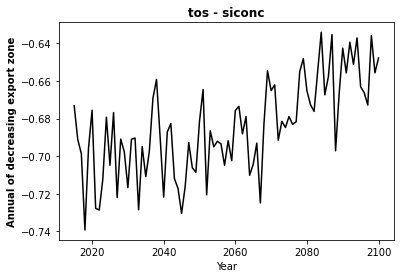

In [45]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec, 'k')
plt.title("{} - siconc".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_siconc_{}_annual_dec_correlation.png".format(model, variable, model))

plt.show()

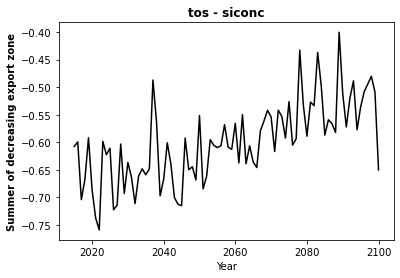

In [46]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec_summer, 'k')
plt.title("{} - siconc".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_siconc_{}_summer_dec_correlation.png".format(model, variable, model))

plt.show()

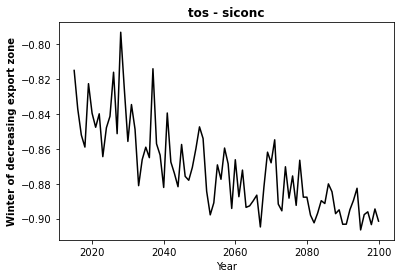

In [47]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec_winter, 'k')
plt.title("{} - siconc".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_siconc_{}_winter_dec_correlation.png".format(model, variable, model))

plt.show()